# Analyzing Fair PCA on different datasets


### Imports


In [1]:
from sklearn.model_selection import train_test_split
import dython
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.tree as tree
import seaborn as sns
import pandas as pd

## Recidivism


In [2]:
df_recidivism = pd.read_csv(f'data/propublica_data_for_fairml.csv')

df_recidivism['Caucasian'] = ((df_recidivism['Other'] == 0) & (df_recidivism['African_American'] == 0) & (
    df_recidivism['Asian'] == 0) & (df_recidivism['Hispanic'] == 0) & (df_recidivism['Native_American'] == 0)).astype(int)
df_recidivism['Between_TwentyFive_And_FourtyFive'] = (
    (df_recidivism['Age_Above_FourtyFive'] == 0) & (df_recidivism['Age_Below_TwentyFive'] == 0)).astype(int)
df_recidivism['Male'] = (df_recidivism['Female'] == 0).astype(int)

# revert one hot encoding
races = ['Other', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Caucasian']
df_recidivism['Race'] = df_recidivism[races].idxmax(axis=1)
df_recidivism = df_recidivism.drop(races, axis=1)

genders = ['Female', 'Male']
df_recidivism['Gender'] = df_recidivism[genders].idxmax(axis=1)
df_recidivism = df_recidivism.drop(genders, axis=1)

age_group = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Between_TwentyFive_And_FourtyFive']
df_recidivism['Age_Group'] = df_recidivism[age_group].idxmax(axis=1)
df_recidivism = df_recidivism.drop(age_group, axis=1)

df_recidivism = df_recidivism.drop('score_factor', axis=1)
df_recidivism = df_recidivism[df_recidivism["Race"].isin(["African_American", "Caucasian"])]
df_recidivism = df_recidivism.reset_index(drop=True)


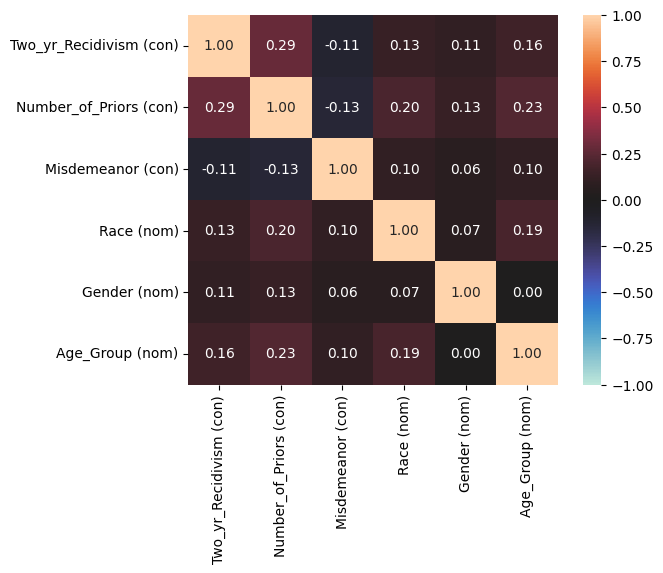

{'corr':                          Two_yr_Recidivism (con)  Number_of_Priors (con)  \
 Two_yr_Recidivism (con)                 1.000000                0.286675   
 Number_of_Priors (con)                  0.286675                1.000000   
 Misdemeanor (con)                      -0.111290               -0.133964   
 Race (nom)                              0.129749                0.195713   
 Gender (nom)                            0.107261                0.127803   
 Age_Group (nom)                         0.160009                0.225212   
 
                          Misdemeanor (con)  Race (nom)  Gender (nom)  \
 Two_yr_Recidivism (con)          -0.111290    0.129749      0.107261   
 Number_of_Priors (con)           -0.133964    0.195713      0.127803   
 Misdemeanor (con)                 1.000000    0.102885      0.063162   
 Race (nom)                        0.102885    1.000000      0.067634   
 Gender (nom)                      0.063162    0.067634      1.000000   
 Age_Group (n

In [3]:
cat_cols = ["Race", "Gender", "Age_Group"]
dython.nominal.associations(df_recidivism, nominal_columns=cat_cols, mark_columns=True)

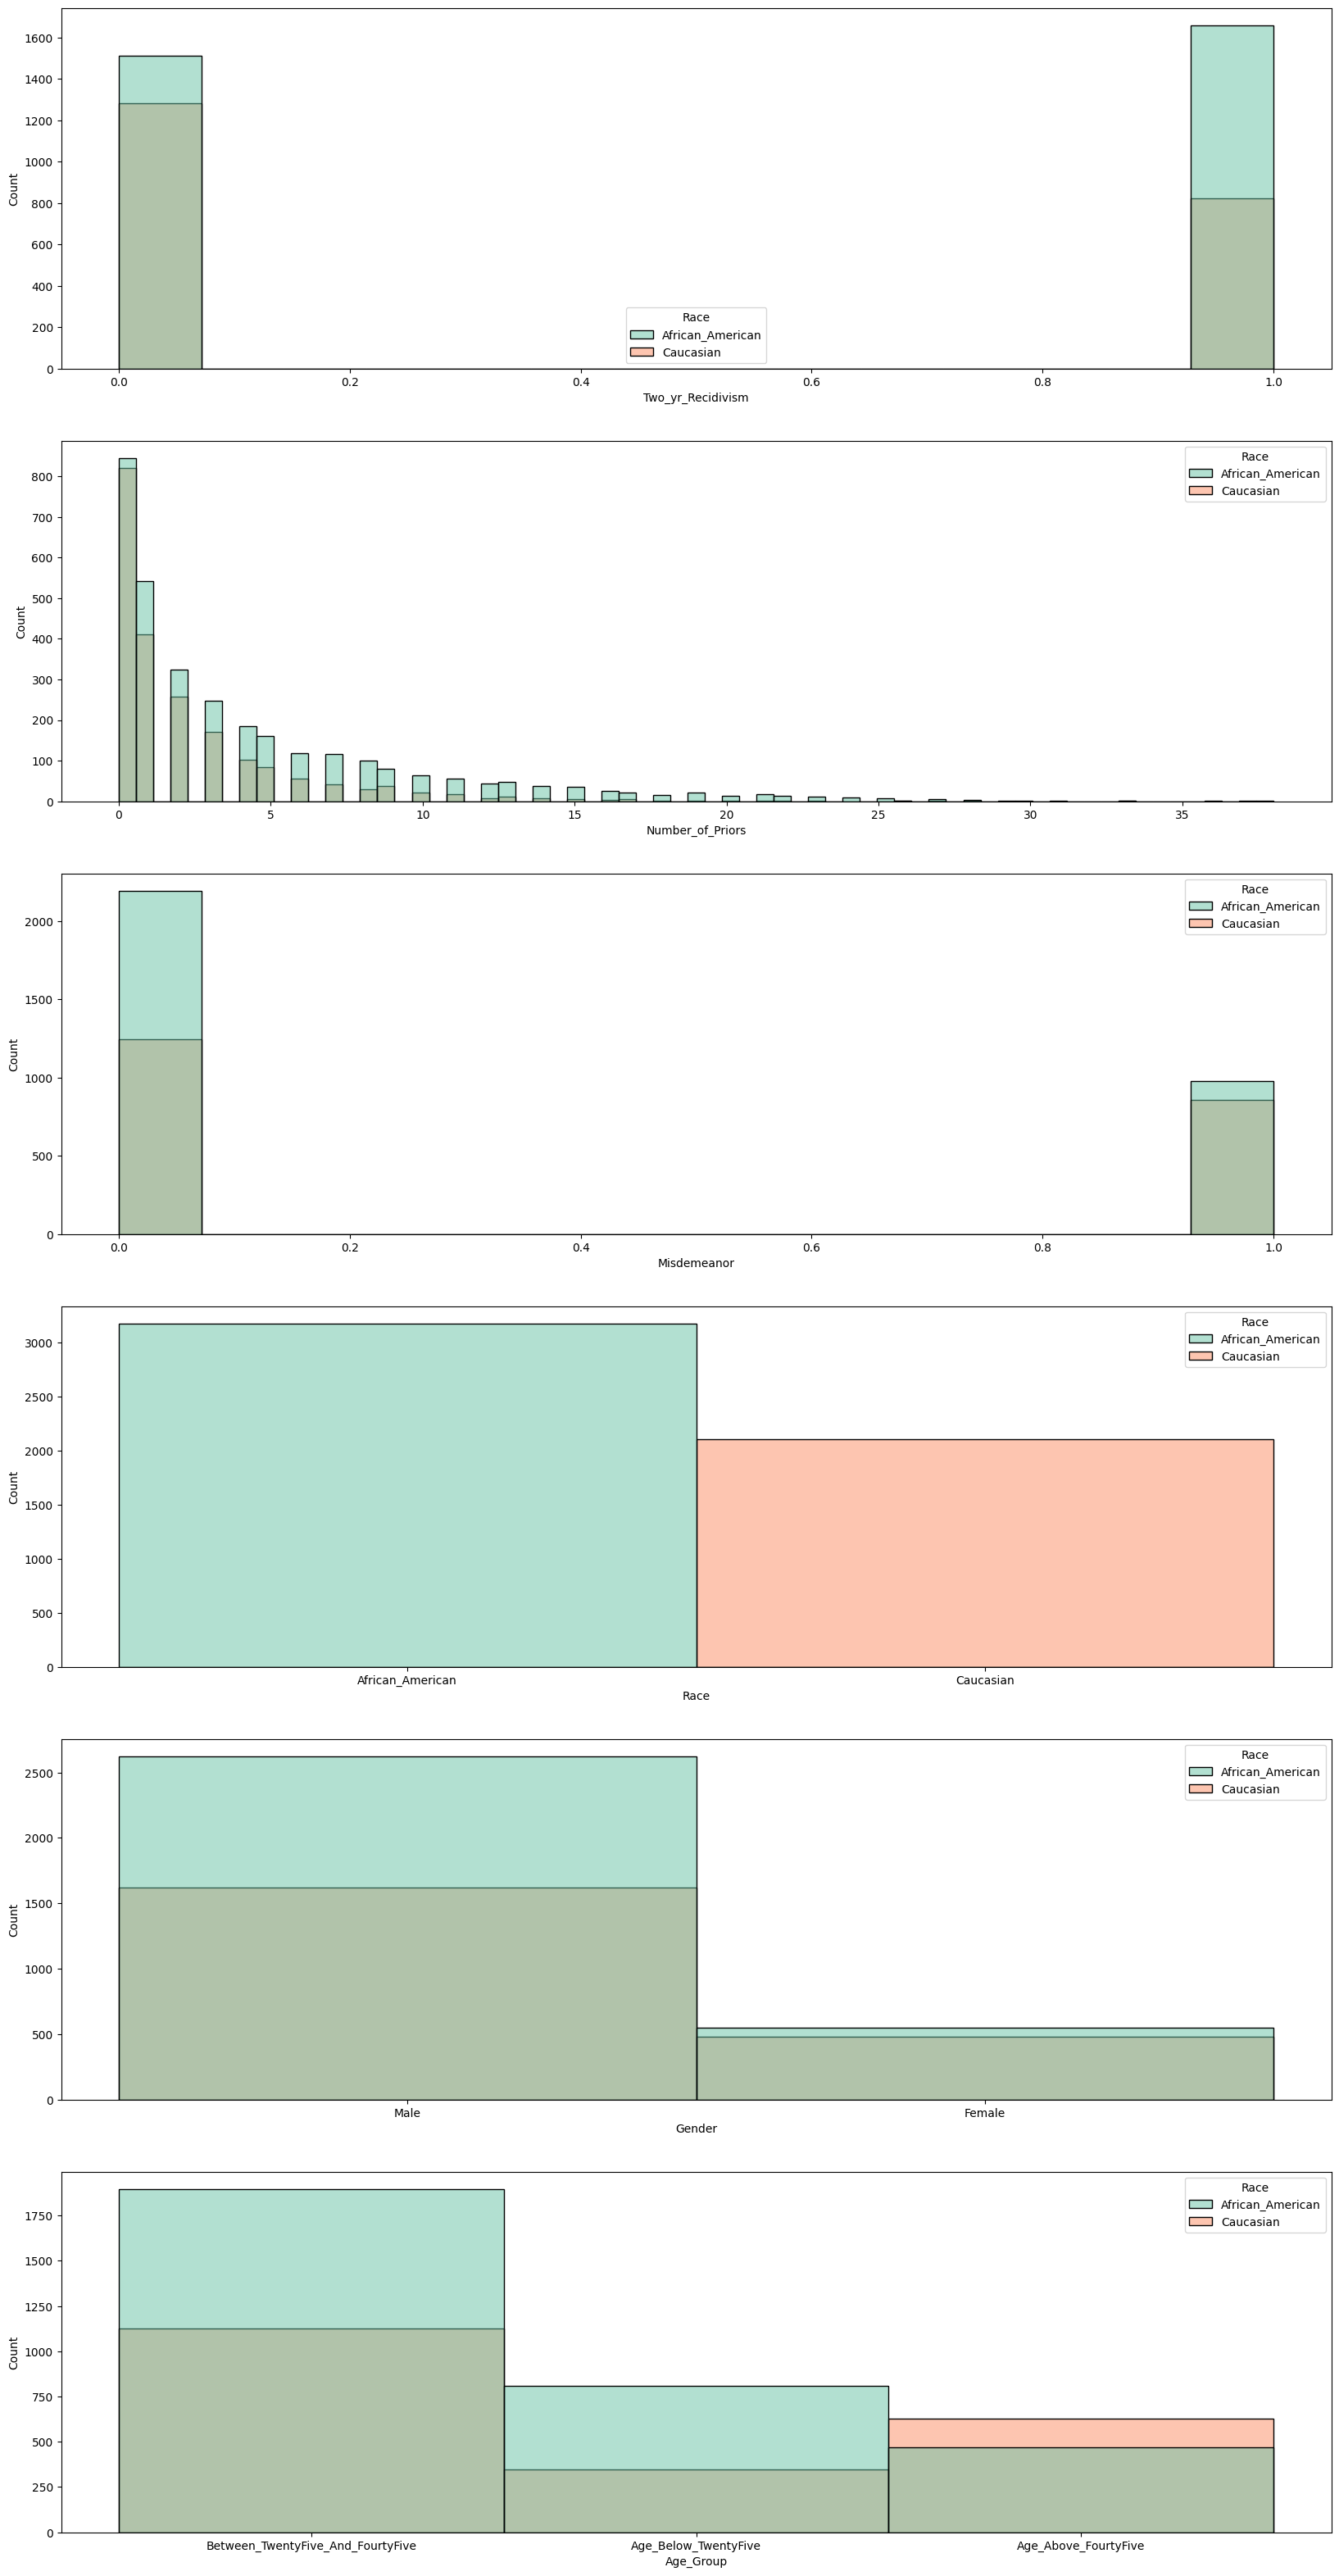

In [4]:
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(len(df_recidivism.columns), figsize=(20, 40))
for i, feature in enumerate(df_recidivism.columns):
    sns.histplot(data=df_recidivism, x=feature, hue='Race', ax=axes[i], palette='Set2')
# plt.show()


In [5]:
# one hot encode data
dummies_df_recividism = pd.get_dummies(df_recidivism, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_recividism.Two_yr_Recidivism
features = dummies_df_recividism.drop("Two_yr_Recidivism", axis=1)

features = features[["Number_of_Priors", "Misdemeanor", "Age_Group_Age_Below_TwentyFive",
                     "Age_Group_Between_TwentyFive_And_FourtyFive", "Race_Caucasian", "Gender_Male"]]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Race" in f) or ("Gender" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 4 (Race_Caucasian)
Column ID: 5 (Gender_Male)
[4, 5]


In [6]:
# last columns of our data contains the protected features
protected = X_train[:, -2:]
nonprotected = X_train[:, :-2]

protected_test = X_test[:, -2:]
nonprotected_test = X_test[:, :-2]


In [7]:
def calculate_metrics(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    recall : float
        Recall of the positive class in binary classification or weighted
        average of the recall of each class for the multiclass task.
    precision : float
        Precision of the positive class in binary classification or weighted
        average of the precision of each class for the multiclass task.
    f1_score : float
        F1 score of the positive class in binary classification or weighted
        average of the F1 score of each class for the multiclass task.
    accuracy : float
        Accuracy of the positive class in binary classification or weighted
        average of the accuracy of each class for the multiclass task.
    """

    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2

    metrics_dict = {'recall': recall,
                    'precision': precision,
                    'f1_score': f1_score,
                    'accuracy': accuracy}
    
    return metrics_dict


In [8]:
def calculate_fairness_metrics_nonencoded(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics

In [9]:
# caluclate statistical parity, equalized odds and equalized outcome for all groups
def calculate_fairness_metrics(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics


def calculate_balanced_accuracy_groups(y_true, y_pred, groups):
    """
    Calculate balanced accuracy for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['balanced_accuracy'] = calculate_metrics(
                y_true_group, y_pred_group)['accuracy']
    return metrics

### with DecisionTreeClassifier


In [10]:
# create decision tree classifier object
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(nonprotected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6664925991863282
Precision on test set: 0.6403385049365303
Recall on test set: 0.628808864265928
F1 score on test set: 0.6345213137665968


In [11]:
def plot_tree(dt, features):
    fig = plt.figure(figsize=(25, 20))
    _ = tree.plot_tree(dt,
                    feature_names=features.columns[:-2],
                    filled=True)

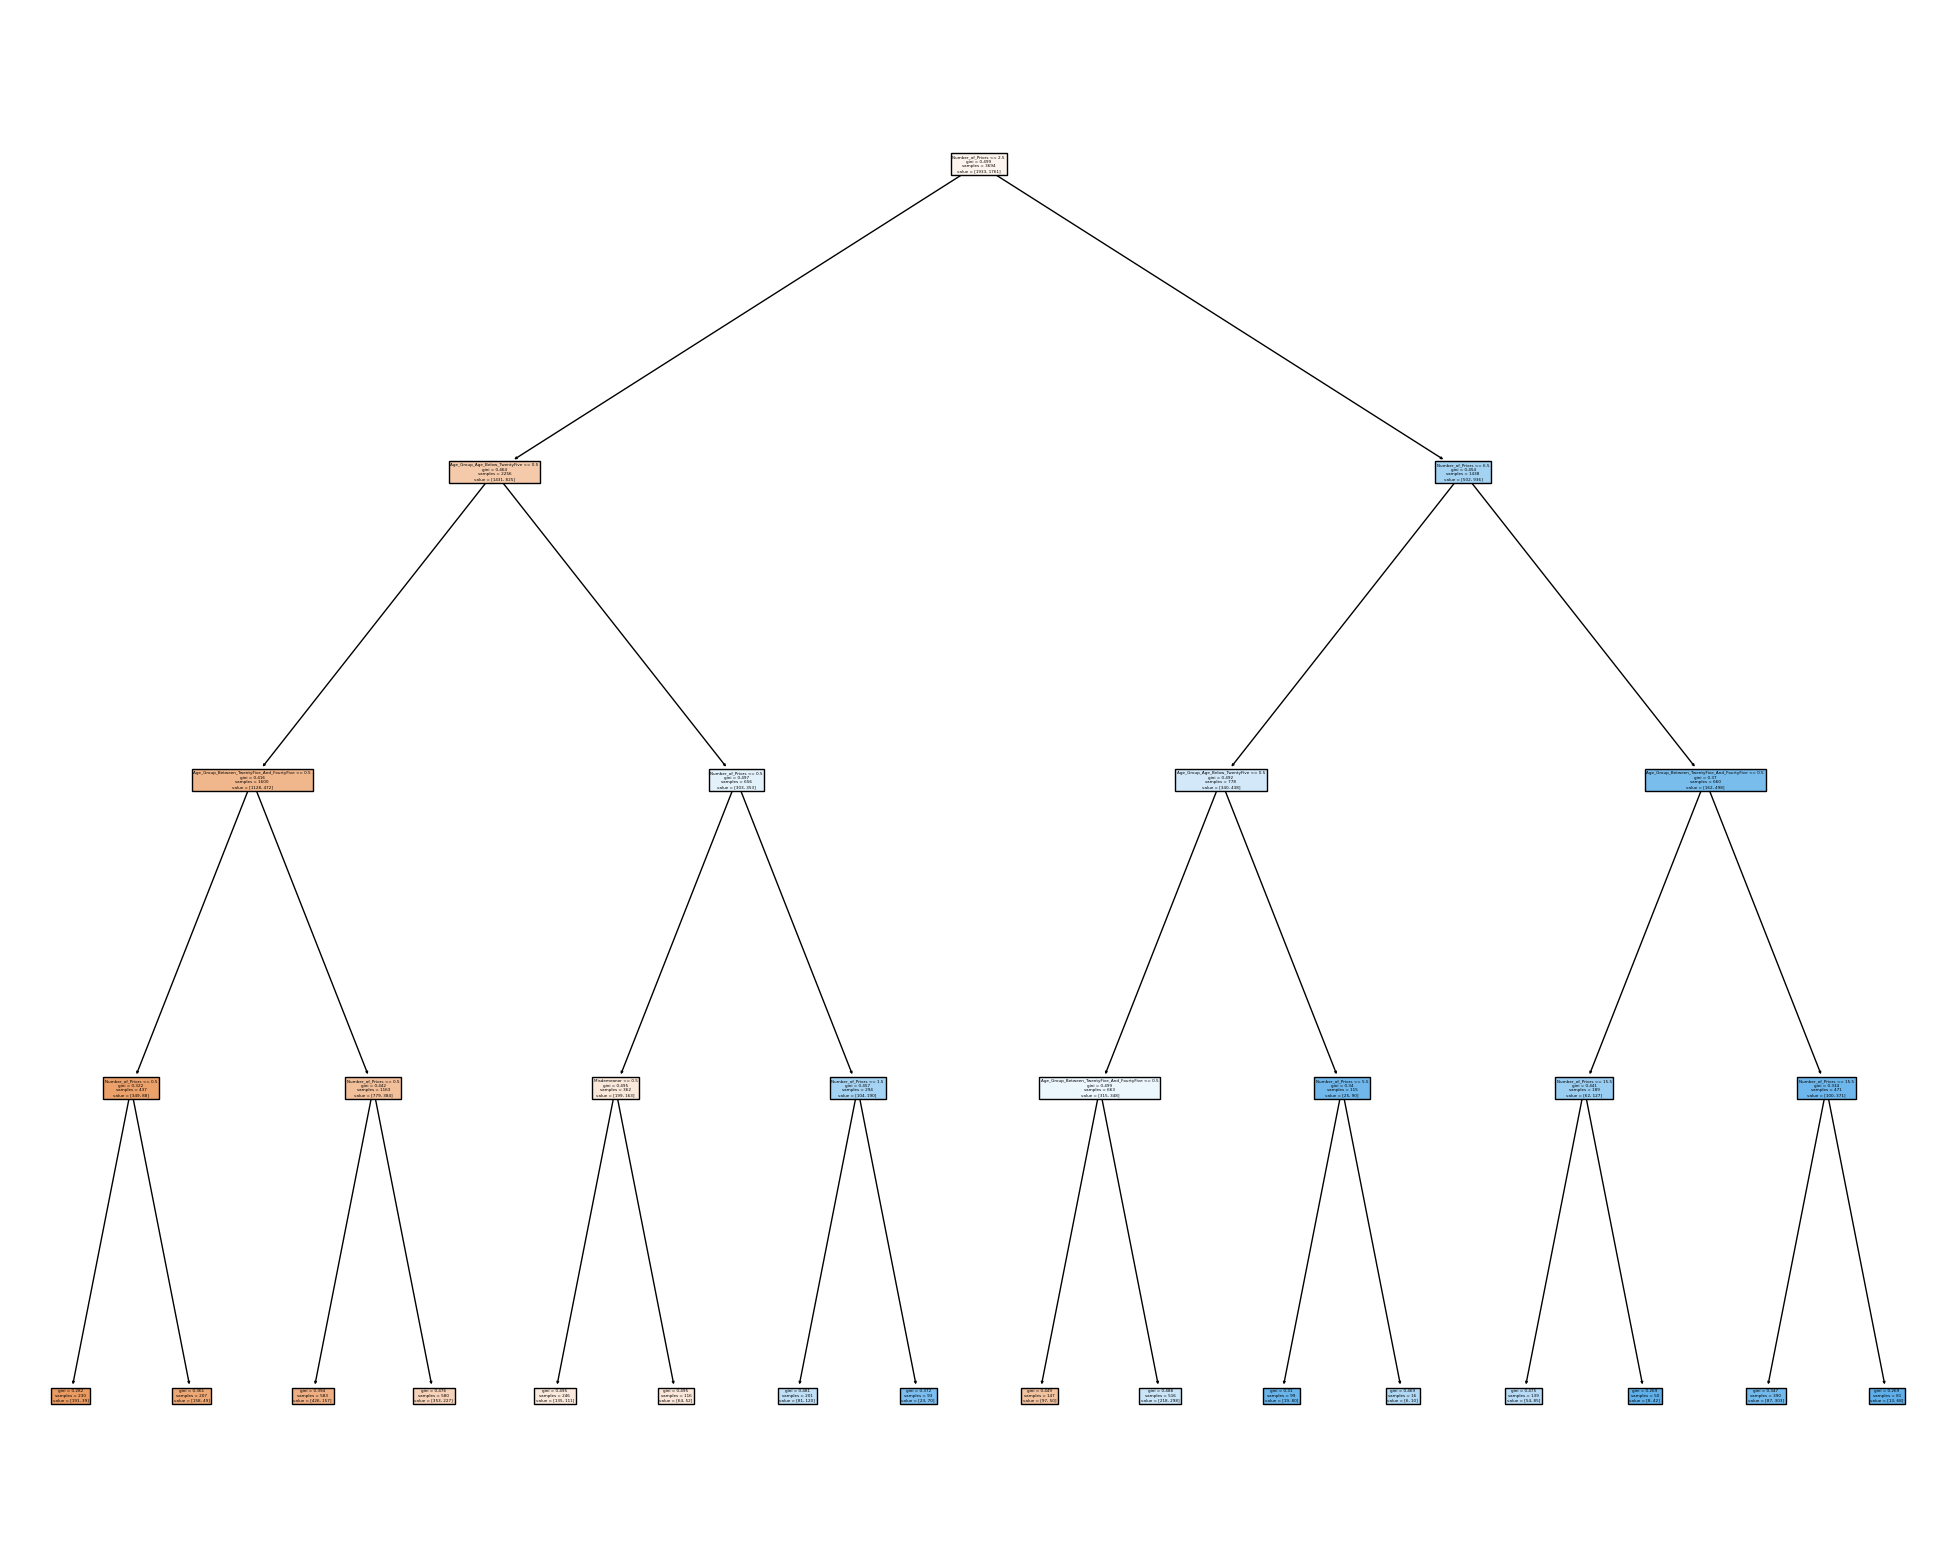

In [12]:
plot_tree(dt, features)

In [13]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.5458333333333333, 'equalized_odds': 0.36592818945760125, 'equalized_outcome': 0.7272727272727273}
Race_Caucasian1 : {'statistical_parity': 0.296474358974359, 'equalized_odds': 0.21354552183567727, 'equalized_outcome': 0.42857142857142855}
Gender_Male0 : {'statistical_parity': 0.2993827160493827, 'equalized_odds': 0.2775148647008858, 'equalized_outcome': 0.4715447154471545}
Gender_Male1 : {'statistical_parity': 0.4857142857142857, 'equalized_odds': 0.3343242267116905, 'equalized_outcome': 0.66110183639399}


In [14]:
# calculate uncertainty by bootstrapping
def calc_certainty(y_test, y_pred):
    n_bootstraps = 1000
    bootstrapped_scores = []
    interval = 0.95
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue

        score = calculate_metrics(y_test[indices], y_pred[indices])['f1_score']
        bootstrapped_scores.append(score)

    print(f"Confidence interval for the f1_score [{interval}]:" + "[{:0.3f} - {:0.3}]".format(
        np.percentile(bootstrapped_scores, ((1-interval)/2)*100),
        np.percentile(bootstrapped_scores, (interval + (1-interval)/2)*100)))

In [15]:
calc_certainty(y_test, y_pred)

Confidence interval for the f1_score [0.95]:[0.602 - 0.664]


### Fair PCA


In [16]:
# apply unfair PCA
def unfair_pca(pca, non_protected_features_scaled):

    X_pca = pca.fit_transform(non_protected_features_scaled)

    # pca.explained_variance_ratio_
    # scree plot bar plot
    plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
    for i in range(len(pca.explained_variance_ratio_)):
        plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
    plt.xlabel('Principal Component')
    plt.show()

    return X_pca

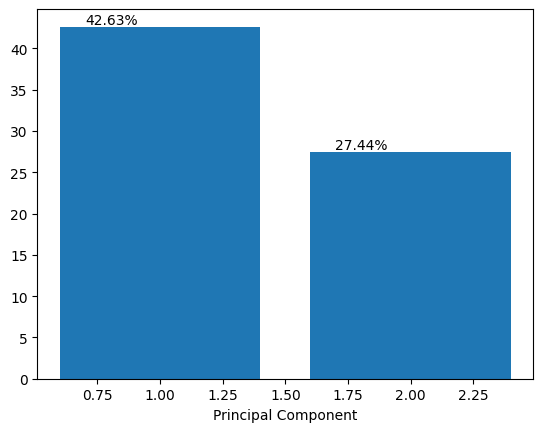

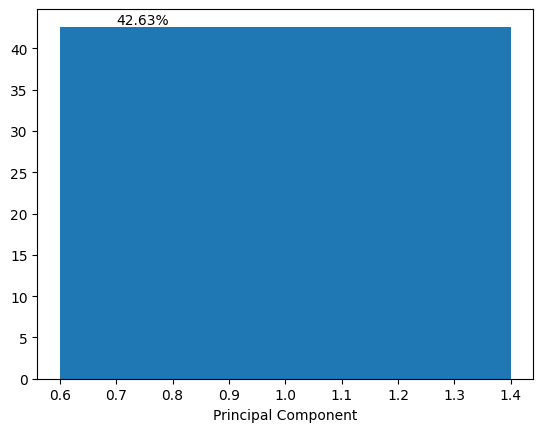

In [17]:
pca_2 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_1 = PCA(n_components=1)
scaler = StandardScaler()

# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_2 = unfair_pca(pca_2, non_protected_features_scaled)
X_pca_1 = unfair_pca(pca_1, non_protected_features_scaled)

In [18]:
def plot_pca_corr(X_pca, protected, groups):

    df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))
    corr = df.corr()
    
    group_list = list(groups.columns)
    pc_list = ["PC" + str(i) for i in range(1, X_pca.shape[1]+1)]
    corr.columns = group_list + pc_list

    rows_to_plot = [x for x in corr.columns if "PC" in x]
    indices_to_plot = range(2)
    corr = corr.loc[indices_to_plot, rows_to_plot]
    indices = ["Race", "Gender"]
    corr.index = indices
    plt.figure(figsize=(24, 3))
    sns.heatmap(corr,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5,
                vmin=-0.2,
                vmax=0.2,
                fmt='.2f');
    plt.show()

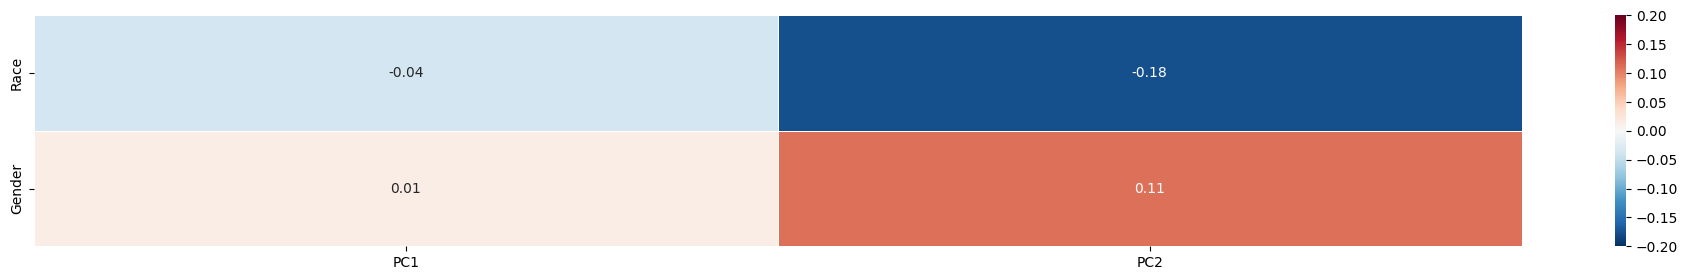

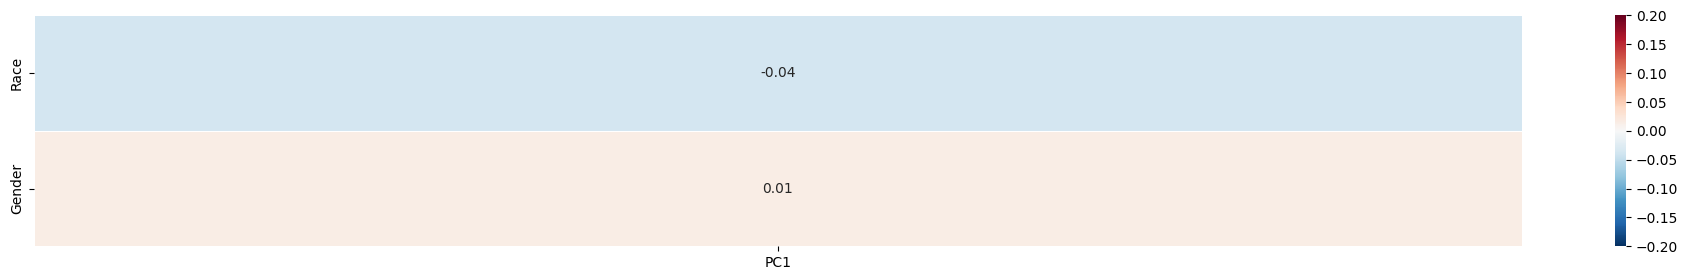

In [19]:
plot_pca_corr(X_pca_2, protected, groups)
plot_pca_corr(X_pca_1, protected, groups)

In [20]:
def reconstruction_error(X_pca_test, pca, non_protected_features_scaled_test):
    # project test data with pca
    X_pca_test = pca.transform(non_protected_features_scaled_test)

    # project it back into the original space
    X_reconstructed_test = pca.inverse_transform(X_pca_test)

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))


In [21]:
# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_2, pca_2, non_protected_features_scaled_test)
print("------------------")
reconstruction_error(X_pca_1, pca_1, non_protected_features_scaled_test)

0.4145796227266717
0.4090418675993554
0.41222689242364396
0.4144574274416096
------------------
0.5957009204231448
0.5822088771054538
0.5947306271441968
0.5919753040952401


In [22]:
# apply fair PCA
import scipy

def fair_pca(non_protected_features_scaled, protected, n_components):
    X = non_protected_features_scaled.copy()
    # create Matrix Z with protected features
    Z = protected.copy()
    # remove mean from each column
    Z = Z - np.mean(Z, axis=0)
    # find orthonormal null space spanned by ZTX with scipy.linalg.null_space
    R = scipy.linalg.null_space(Z.T @ X)

    # Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
    eigvals, eigvecs = scipy.linalg.eig((R.T @ X.T) @ (X @ R))
    # sort eigenvectors by eigenvalues
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # get matrix of first n eigenvectors
    L = eigvecs[:,:n_components]

    # projection matrix U = RL
    U = R @ L

    # project data
    X_projected = X @ U

    return X_projected, Z, U


In [23]:
X_projected_2, Z_2, U_2 = fair_pca(non_protected_features_scaled, protected, 2)
X_projected_1, Z_1, U_1 = fair_pca(non_protected_features_scaled, protected, 1)

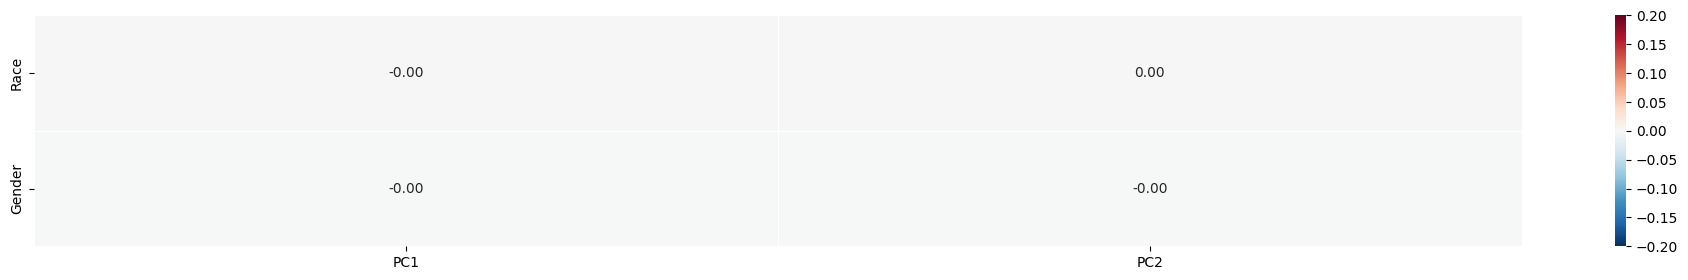

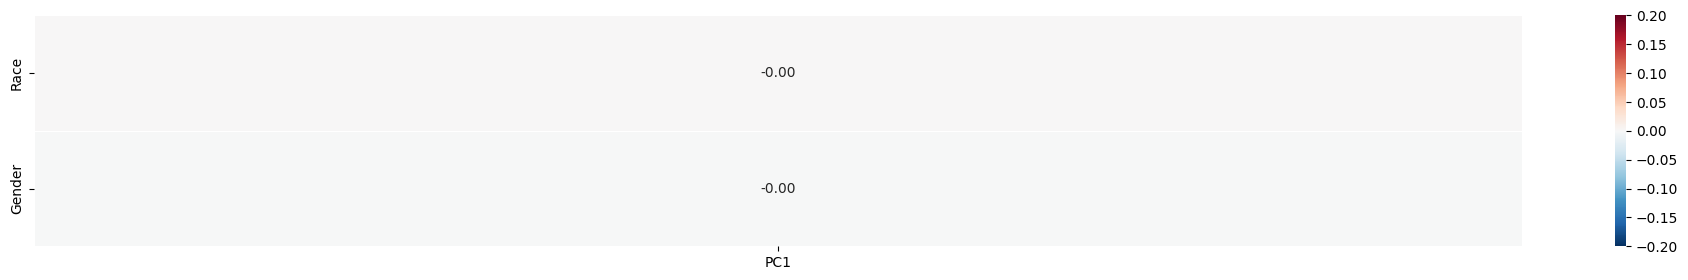

In [24]:
plot_pca_corr(X_projected_2, protected, groups)
plot_pca_corr(X_projected_1, protected, groups)

In [25]:
def reconstruction_error_fair_pca(X_projected, X_test_projected, U, non_protected_features_scaled_test):

    # reproject it back into the original space
    X_reconstructed = X_projected @ U.T
    X_reconstructed_test = X_test_projected @ U.T

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error = []
    for i in range(len(non_protected_features_scaled)):
        reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))

In [26]:
# project test data
X_test_projected_2 = non_protected_features_scaled_test @ U_2
X_test_projected_1 = non_protected_features_scaled_test @ U_1

reconstruction_error_fair_pca(X_projected_2, X_test_projected_2, U_2, non_protected_features_scaled_test)
print("------------------")
reconstruction_error_fair_pca(X_projected_1, X_test_projected_1, U_1, non_protected_features_scaled_test)

0.43574020287276527
0.42470874673700904
0.4383123336754717
0.43027134025040603
------------------
0.5796073267982758
0.5682626939281706
0.5769771440379733
0.5777807600700551


Balanced accuracy on test set: 0.6203829270330546
Precision on test set: 0.6329588014981273
Recall on test set: 0.46814404432132967
F1 score on test set: 0.5382165605095542


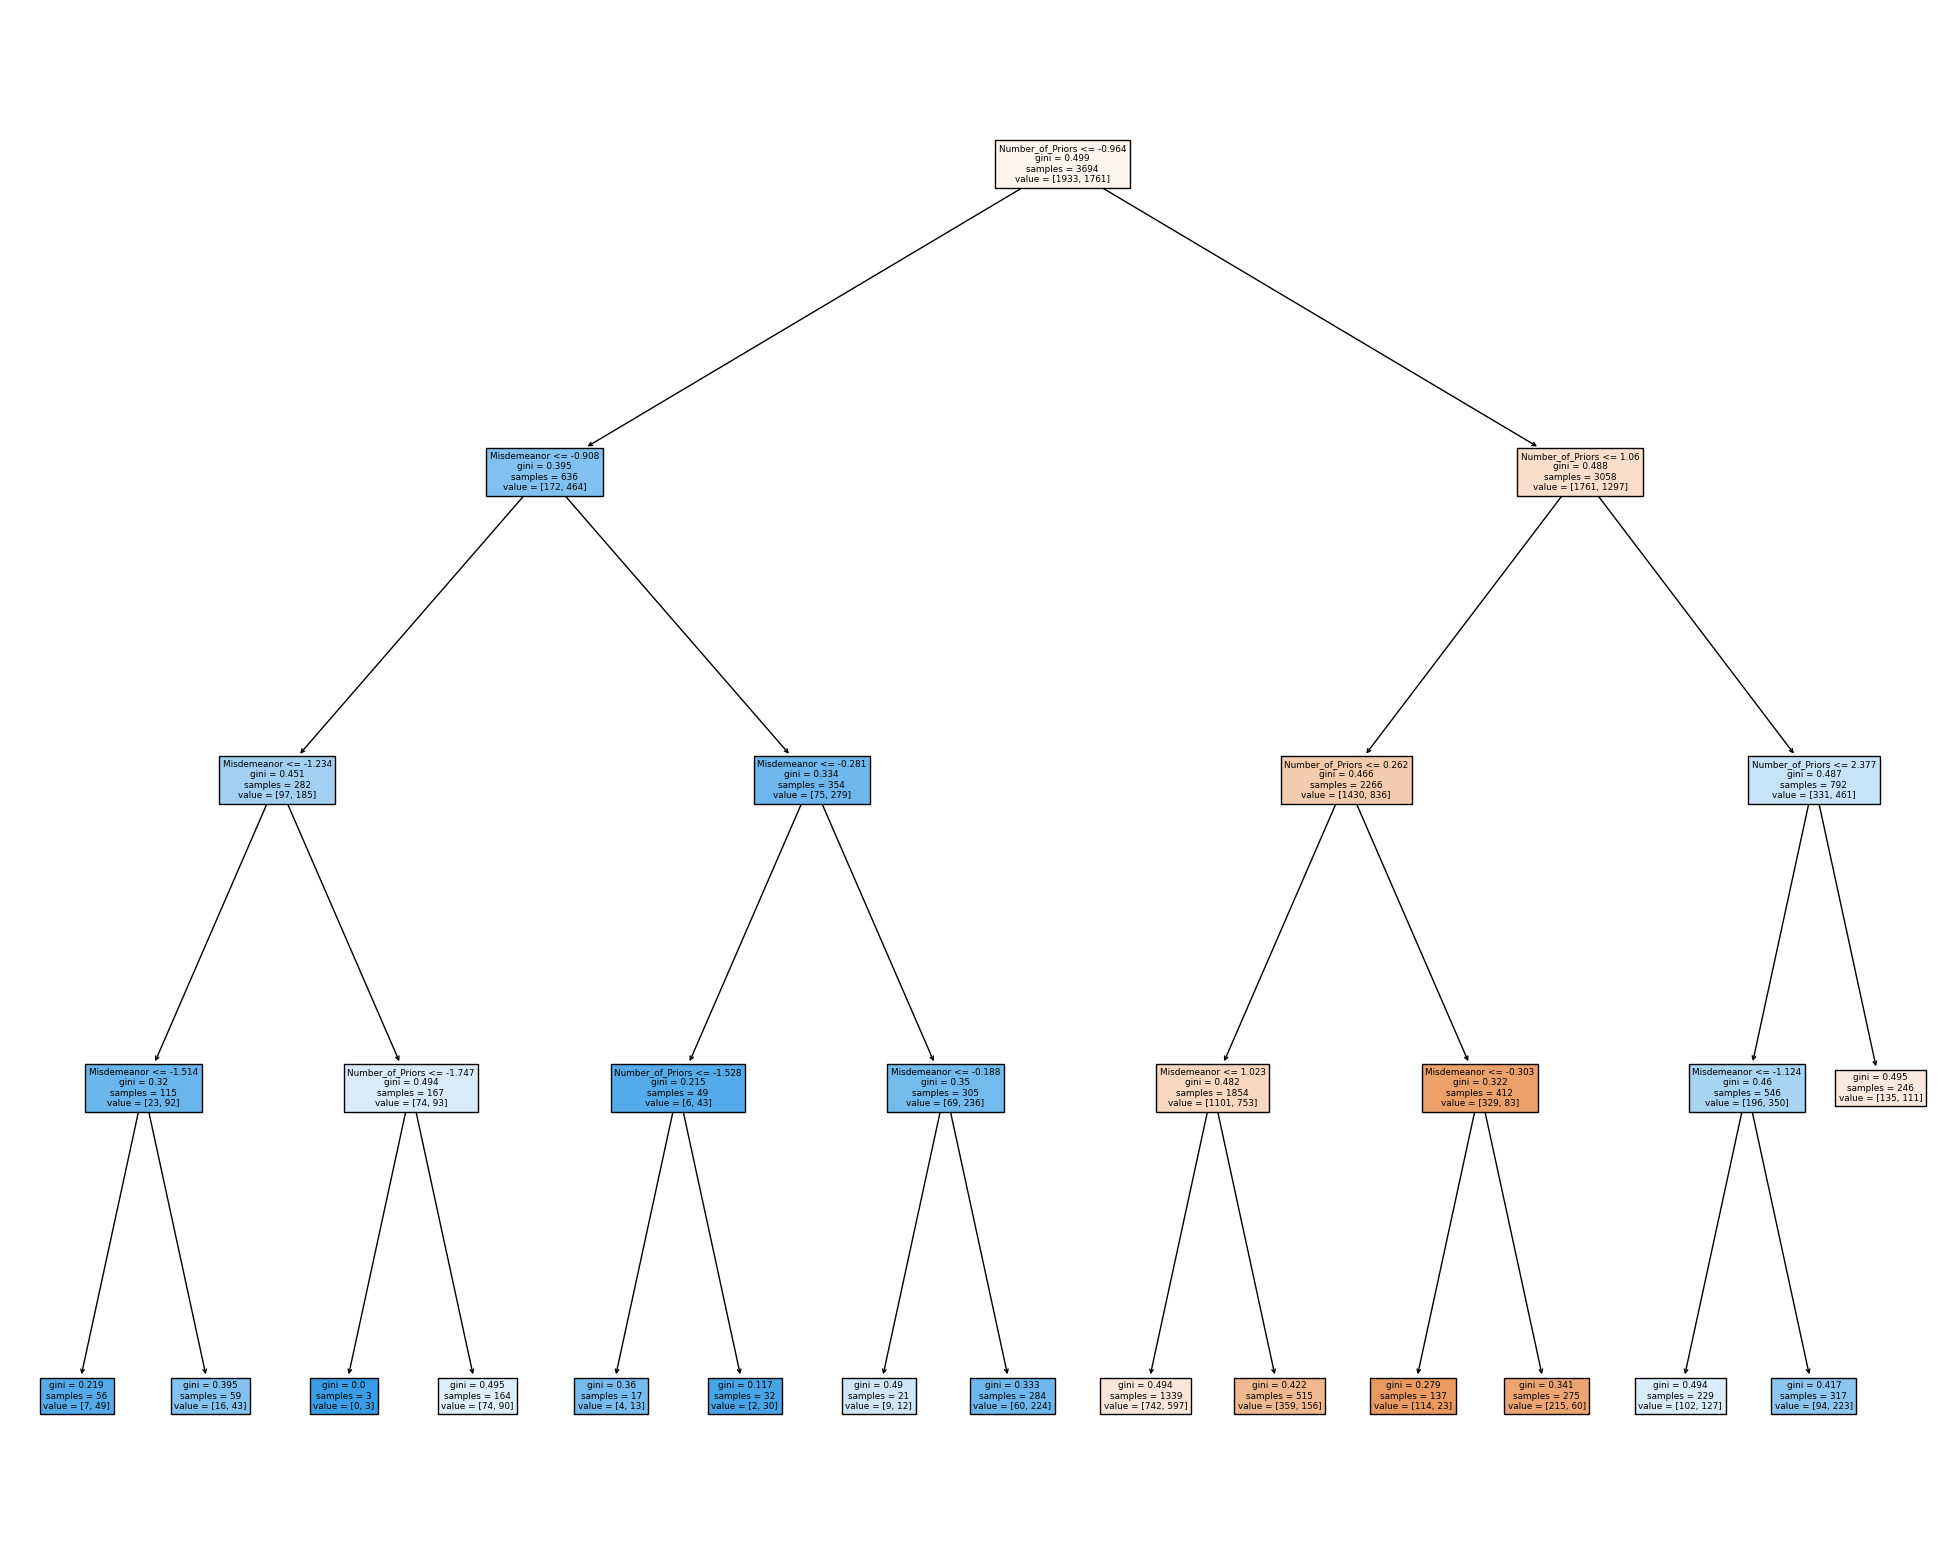

In [27]:
# run decision tree on fair PCA data with 2 components
dt_2 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_2.fit(X_projected_2, y_train)
# evaluate the model on the test set
y_pred_2 = dt_2.predict(X_test_projected_2)
metric_scores_2 = calculate_metrics(y_test, y_pred_2)
print("Balanced accuracy on test set:", metric_scores_2['accuracy'])
print("Precision on test set:", metric_scores_2['precision'])
print("Recall on test set:", metric_scores_2['recall'])
print("F1 score on test set:", metric_scores_2['f1_score'])
plot_tree(dt_2, features)

Balanced accuracy on test set: 0.6187906112821435
Precision on test set: 0.6363636363636364
Recall on test set: 0.4556786703601108
F1 score on test set: 0.5310734463276837


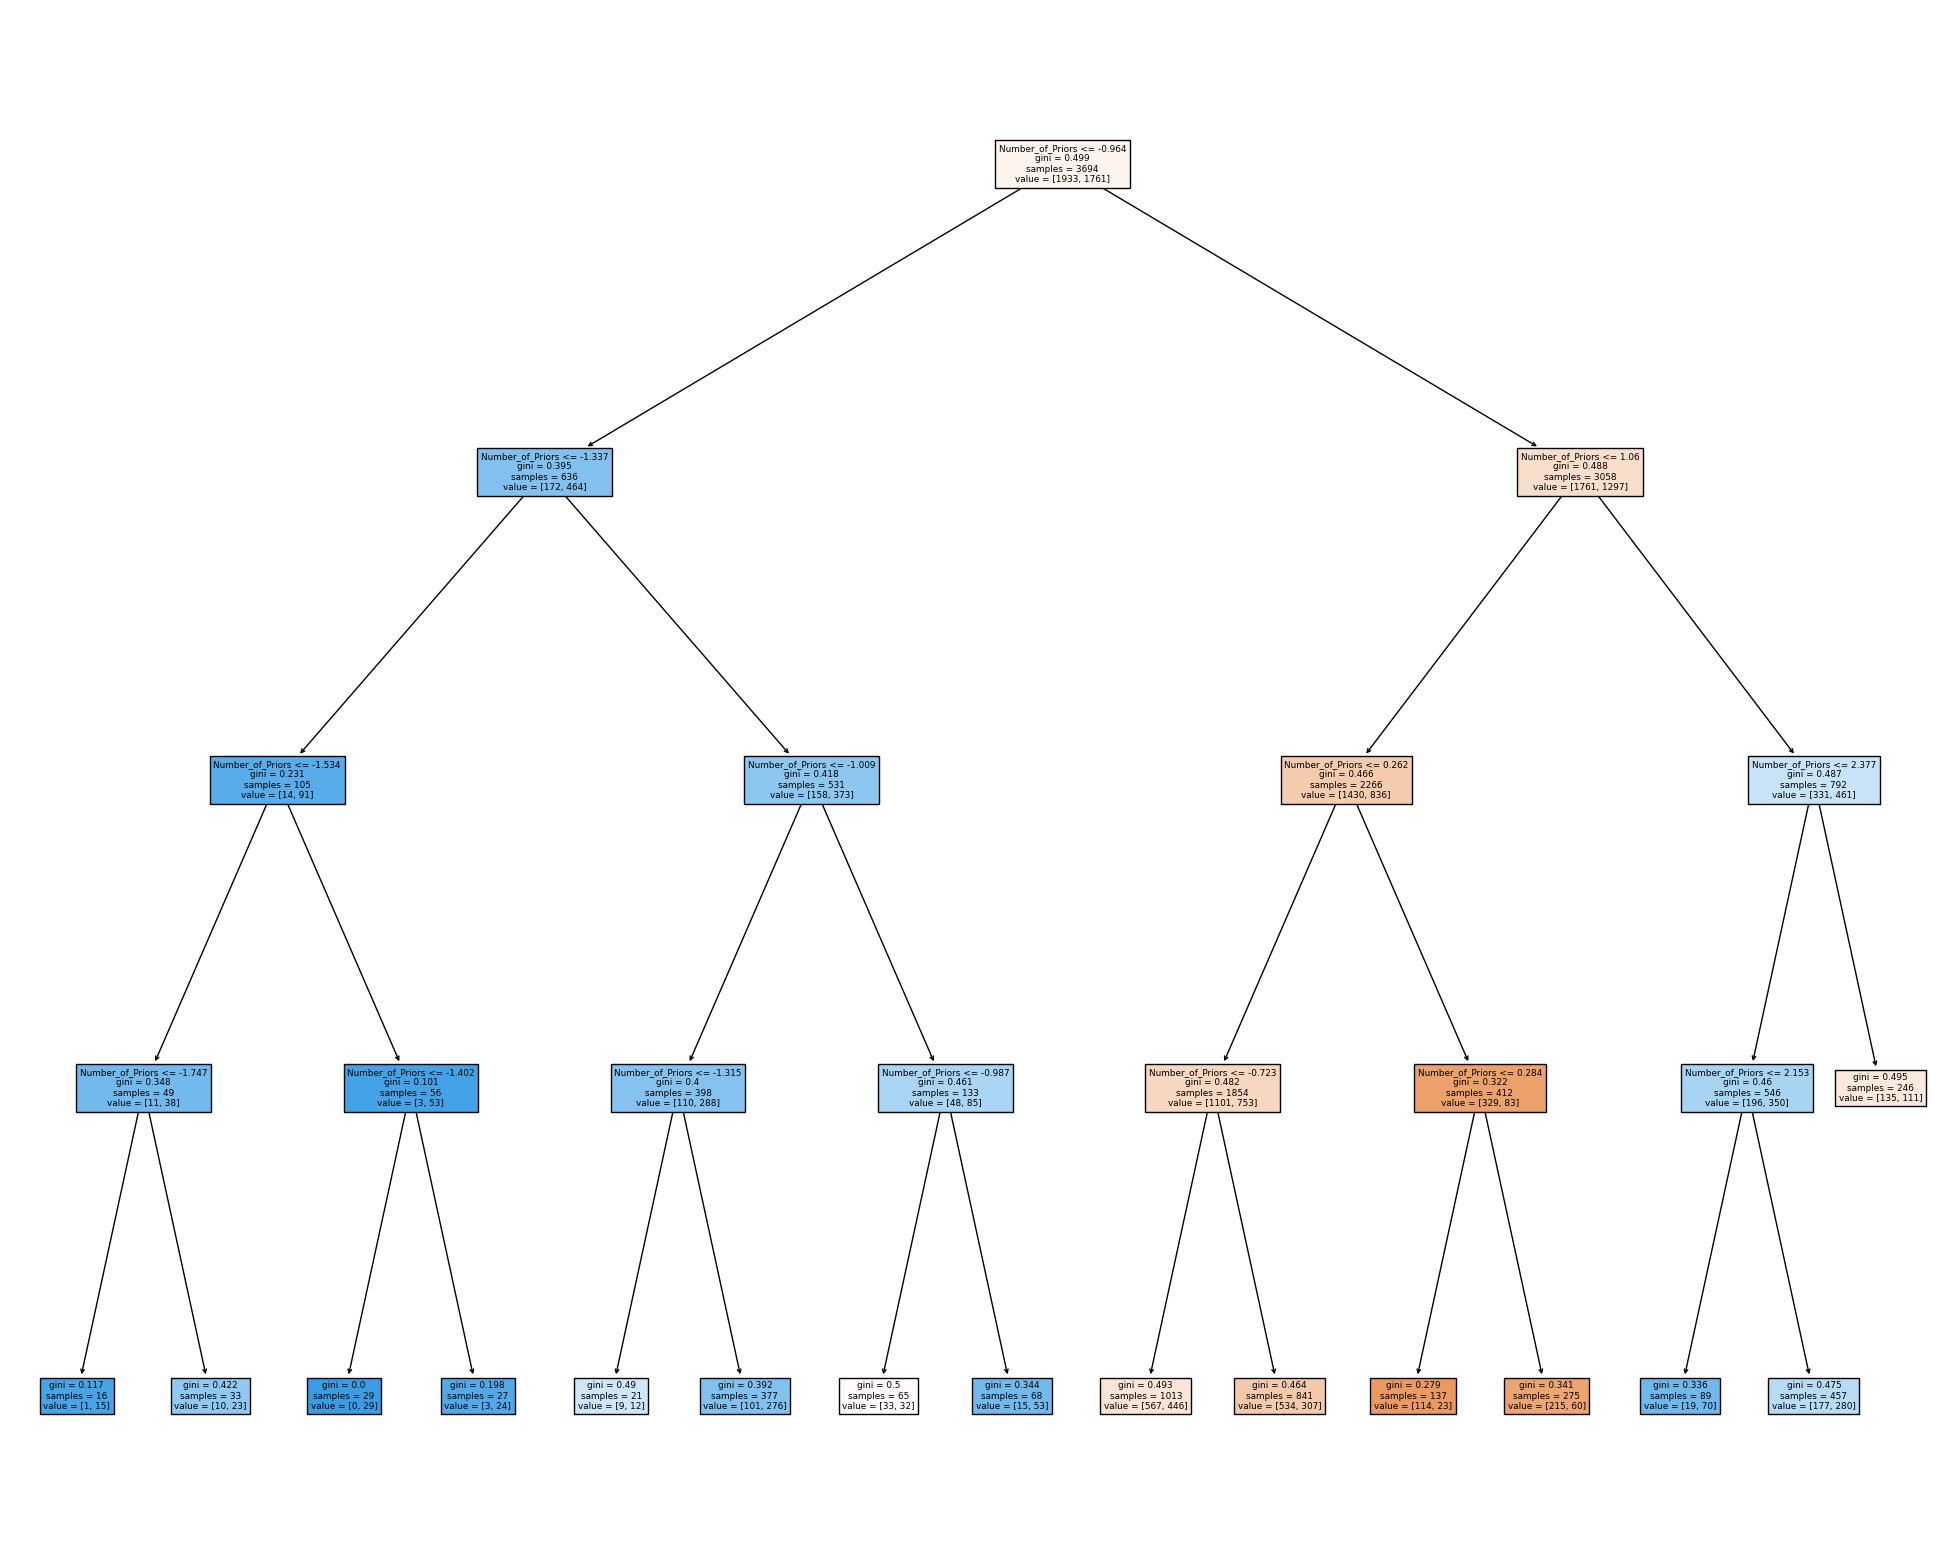

In [28]:
# run decision tree on fair PCA data with 1 component
dt_1 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_1.fit(X_projected_1, y_train)
# evaluate the model on the test set
y_pred_1 = dt_1.predict(X_test_projected_1)
metric_scores_1 = calculate_metrics(y_test, y_pred_1)
print("Balanced accuracy on test set:", metric_scores_1['accuracy'])
print("Precision on test set:", metric_scores_1['precision'])
print("Recall on test set:", metric_scores_1['recall'])
print("F1 score on test set:", metric_scores_1['f1_score'])
plot_tree(dt_1, features)

In [29]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.5458333333333333, 'equalized_odds': 0.36592818945760125, 'equalized_outcome': 0.7272727272727273}
Race_Caucasian1 : {'statistical_parity': 0.296474358974359, 'equalized_odds': 0.21354552183567727, 'equalized_outcome': 0.42857142857142855}
Gender_Male0 : {'statistical_parity': 0.2993827160493827, 'equalized_odds': 0.2775148647008858, 'equalized_outcome': 0.4715447154471545}
Gender_Male1 : {'statistical_parity': 0.4857142857142857, 'equalized_odds': 0.3343242267116905, 'equalized_outcome': 0.66110183639399}


## Wage Equality


In [30]:
# Dataset from https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/Stock-Watson-EmpiricalExercises-DataSets.htm
# Prottected attribute is 'female'. Target is 'eanwke'

# All values are int or float already
df_weekly_earn = pd.read_csv('data/employment.csv')

# Drop 600 rows of the total 5000 rows, which have nan values
df_weekly_earn = df_weekly_earn.dropna()
df_weekly_earn = df_weekly_earn[df_weekly_earn["race"] != 3] # drop other race
df_weekly_earn['race'] = df_weekly_earn['race'] - 1 # 0 is white, 1 is african american
df_weekly_earn = df_weekly_earn.drop(['self', 'private'], axis=1) # drop self employed, private employed cause opposite of "government" column

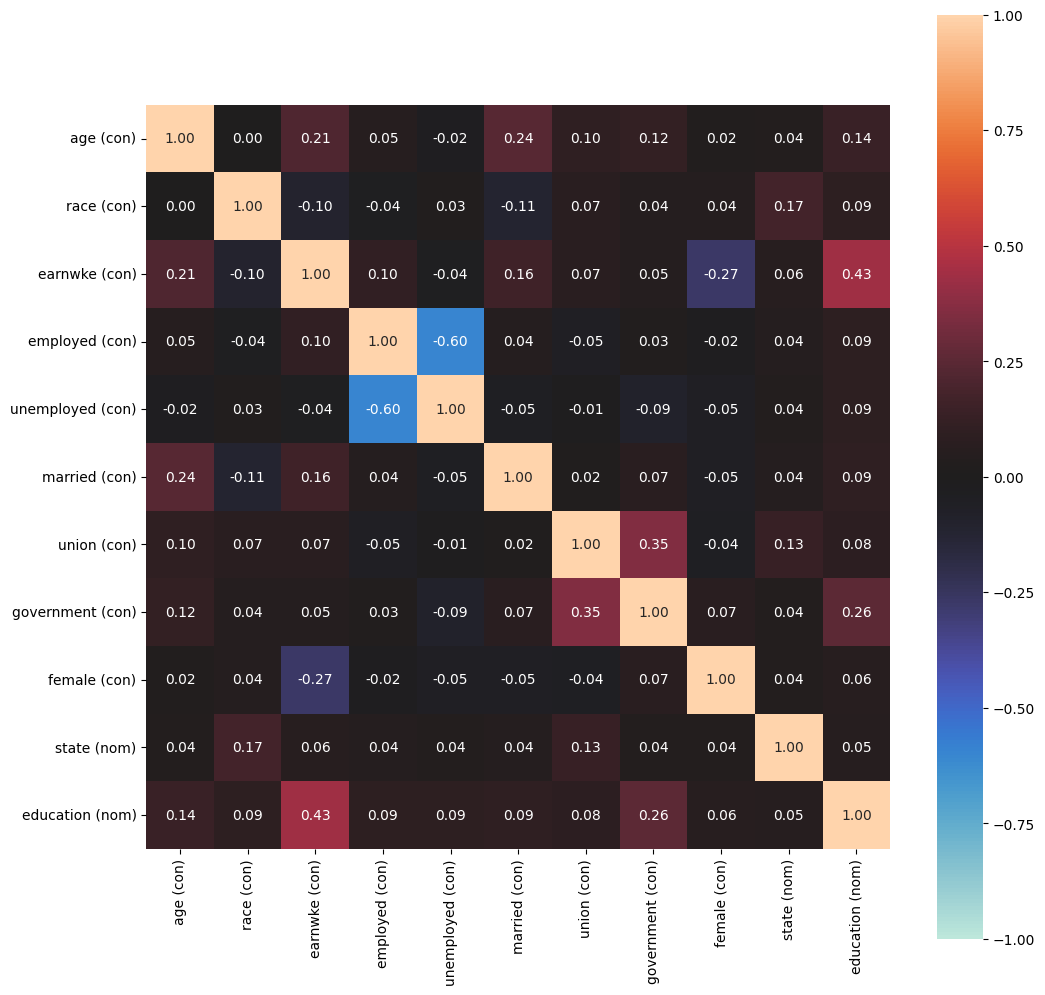

In [31]:
df_weekly_no_dummies = df_weekly_earn.copy()
# create a new 'state' column by using the column names to map to the desired values
df_weekly_no_dummies['state'] = df_weekly_no_dummies.apply(lambda row: 'ne' if row['ne_states'] == 1 else ('so' if row['so_states'] == 1 else ('ce' if row['ce_states'] == 1 else 'we')), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['ne_states', 'so_states', 'ce_states', 'we_states'], axis=1)

# create a new 'education' column by using the column names to map to the desired values
df_weekly_no_dummies['education'] = df_weekly_no_dummies.apply(lambda row: "less than high school" if row['educ_lths'] == 1 else ("high school" if row['educ_hs'] == 1 else ("some college" if row['educ_somecol'] == 1 else ("associate's degree" if row['educ_aa'] == 1 else ("bachelor's degree" if row['educ_bac'] == 1 else "advanced degree")))), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv'], axis=1)

# get list of categorical columns
num_cols = df_weekly_no_dummies._get_numeric_data().columns
cat_cols = list(set(df_weekly_no_dummies.columns) - set(num_cols))


dython.nominal.associations(
    df_weekly_no_dummies, nominal_columns=cat_cols, mark_columns=True, figsize=(12, 12));

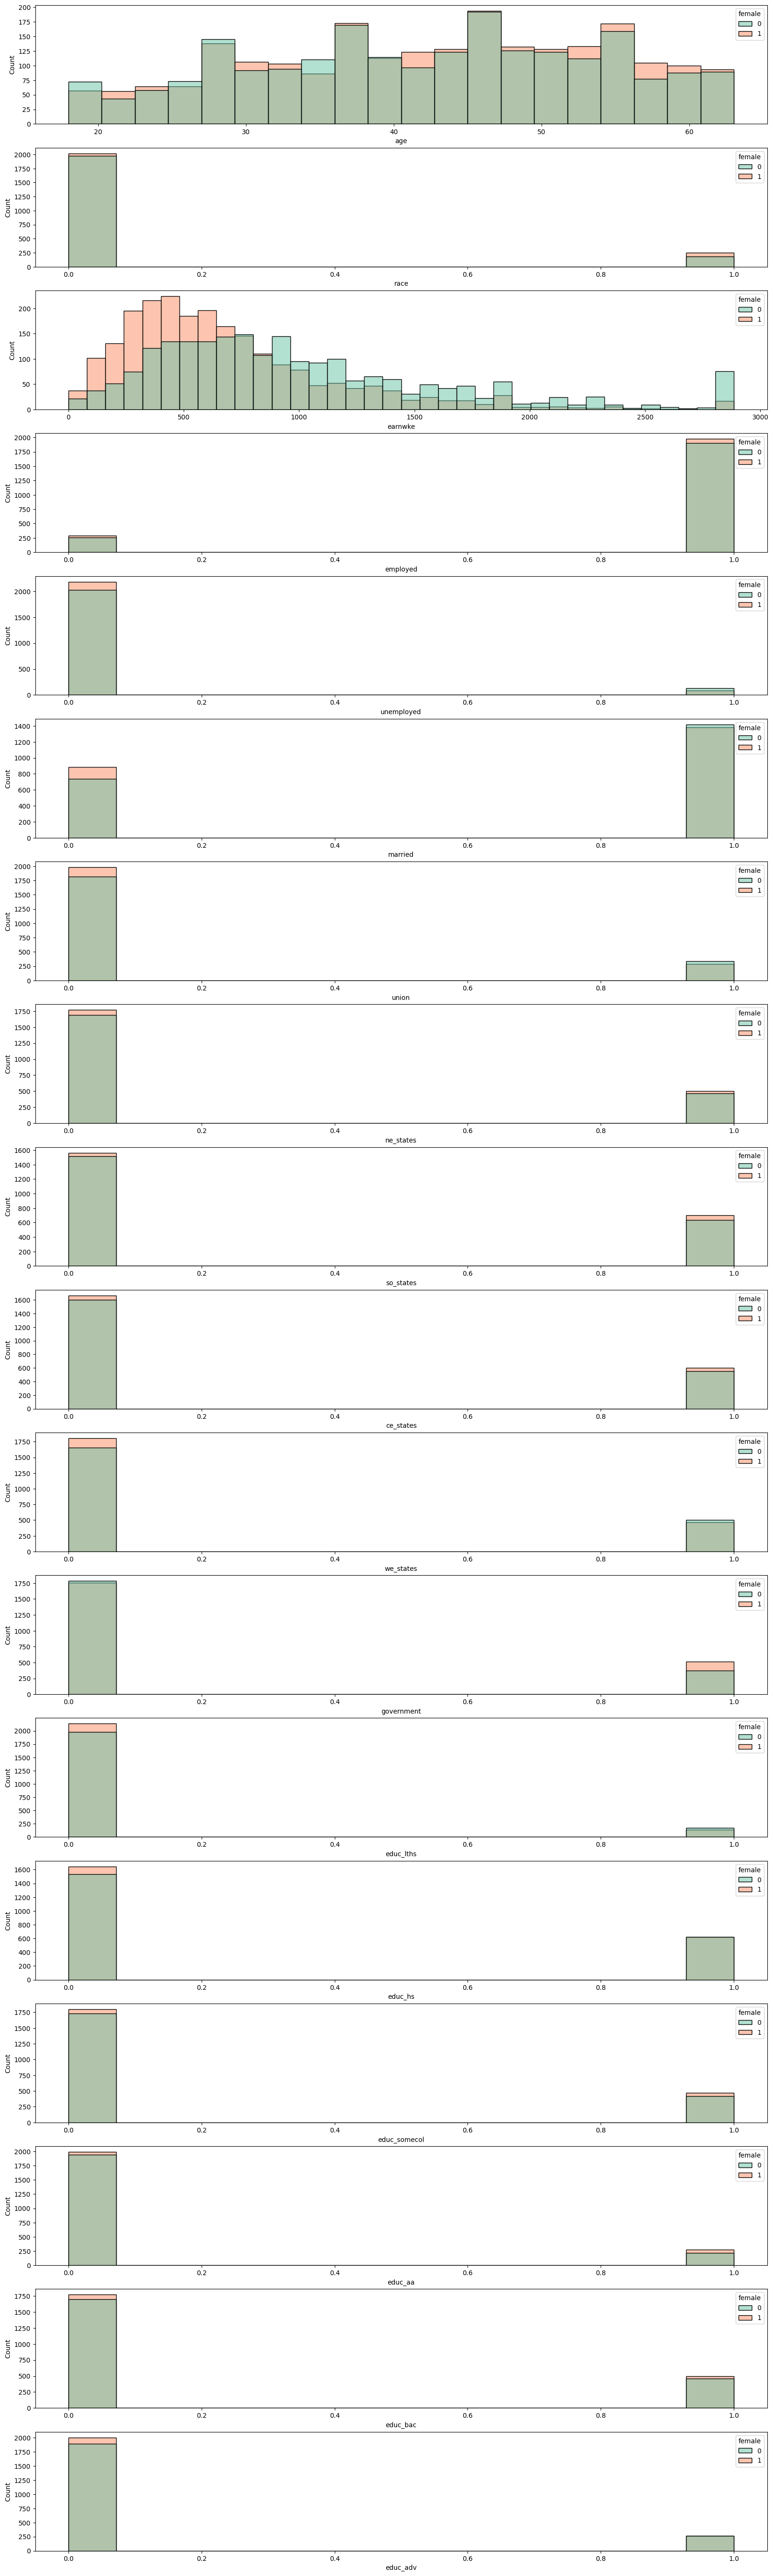

In [32]:
fig, axes = plt.subplots(len(df_weekly_earn.columns)-1, figsize=(20, 70))
for i, feature in enumerate(df_weekly_earn.columns[:-1]):
    sns.histplot(data=df_weekly_earn, x=feature, hue='female', ax=axes[i], palette='Set2')
plt.show()

In [33]:
median = df_weekly_earn['earnwke'].median()
df_weekly_earn['earnwke'] = (df_weekly_earn['earnwke'] >= median).astype(int)

In [34]:

# remove target variable from features
labels = df_weekly_earn.earnwke
features = df_weekly_earn.drop("earnwke", axis=1)

# reorder so cloumns with "Gender" or "age" in them are at the end
cols = list(features.columns)
protected_cols = []
for i, col in enumerate(cols):
    if ("race" in col) or ("female" in col):
        protected_cols.append(col)

cols = list(set(cols) - set(protected_cols))

cols = cols + protected_cols
features = features[cols]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("race" in f) or ("female" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 16 (race)
Column ID: 17 (female)
[16, 17]


In [35]:
# last columns of our data contains the protected features
prot_groups = len(indices)
protected = X_train[:, -prot_groups:]
nonprotected = X_train[:, :-prot_groups]

protected_test = X_test[:, -prot_groups:]
nonprotected_test = X_test[:, :-prot_groups]

In [36]:
# create decision tree classifier object
dt = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt.fit(nonprotected, y_train)
# evaluate the model on the test set
y_pred = dt.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6505549052169257
Precision on test set: 0.683206106870229
Recall on test set: 0.5474006116207951
F1 score on test set: 0.6078098471986418


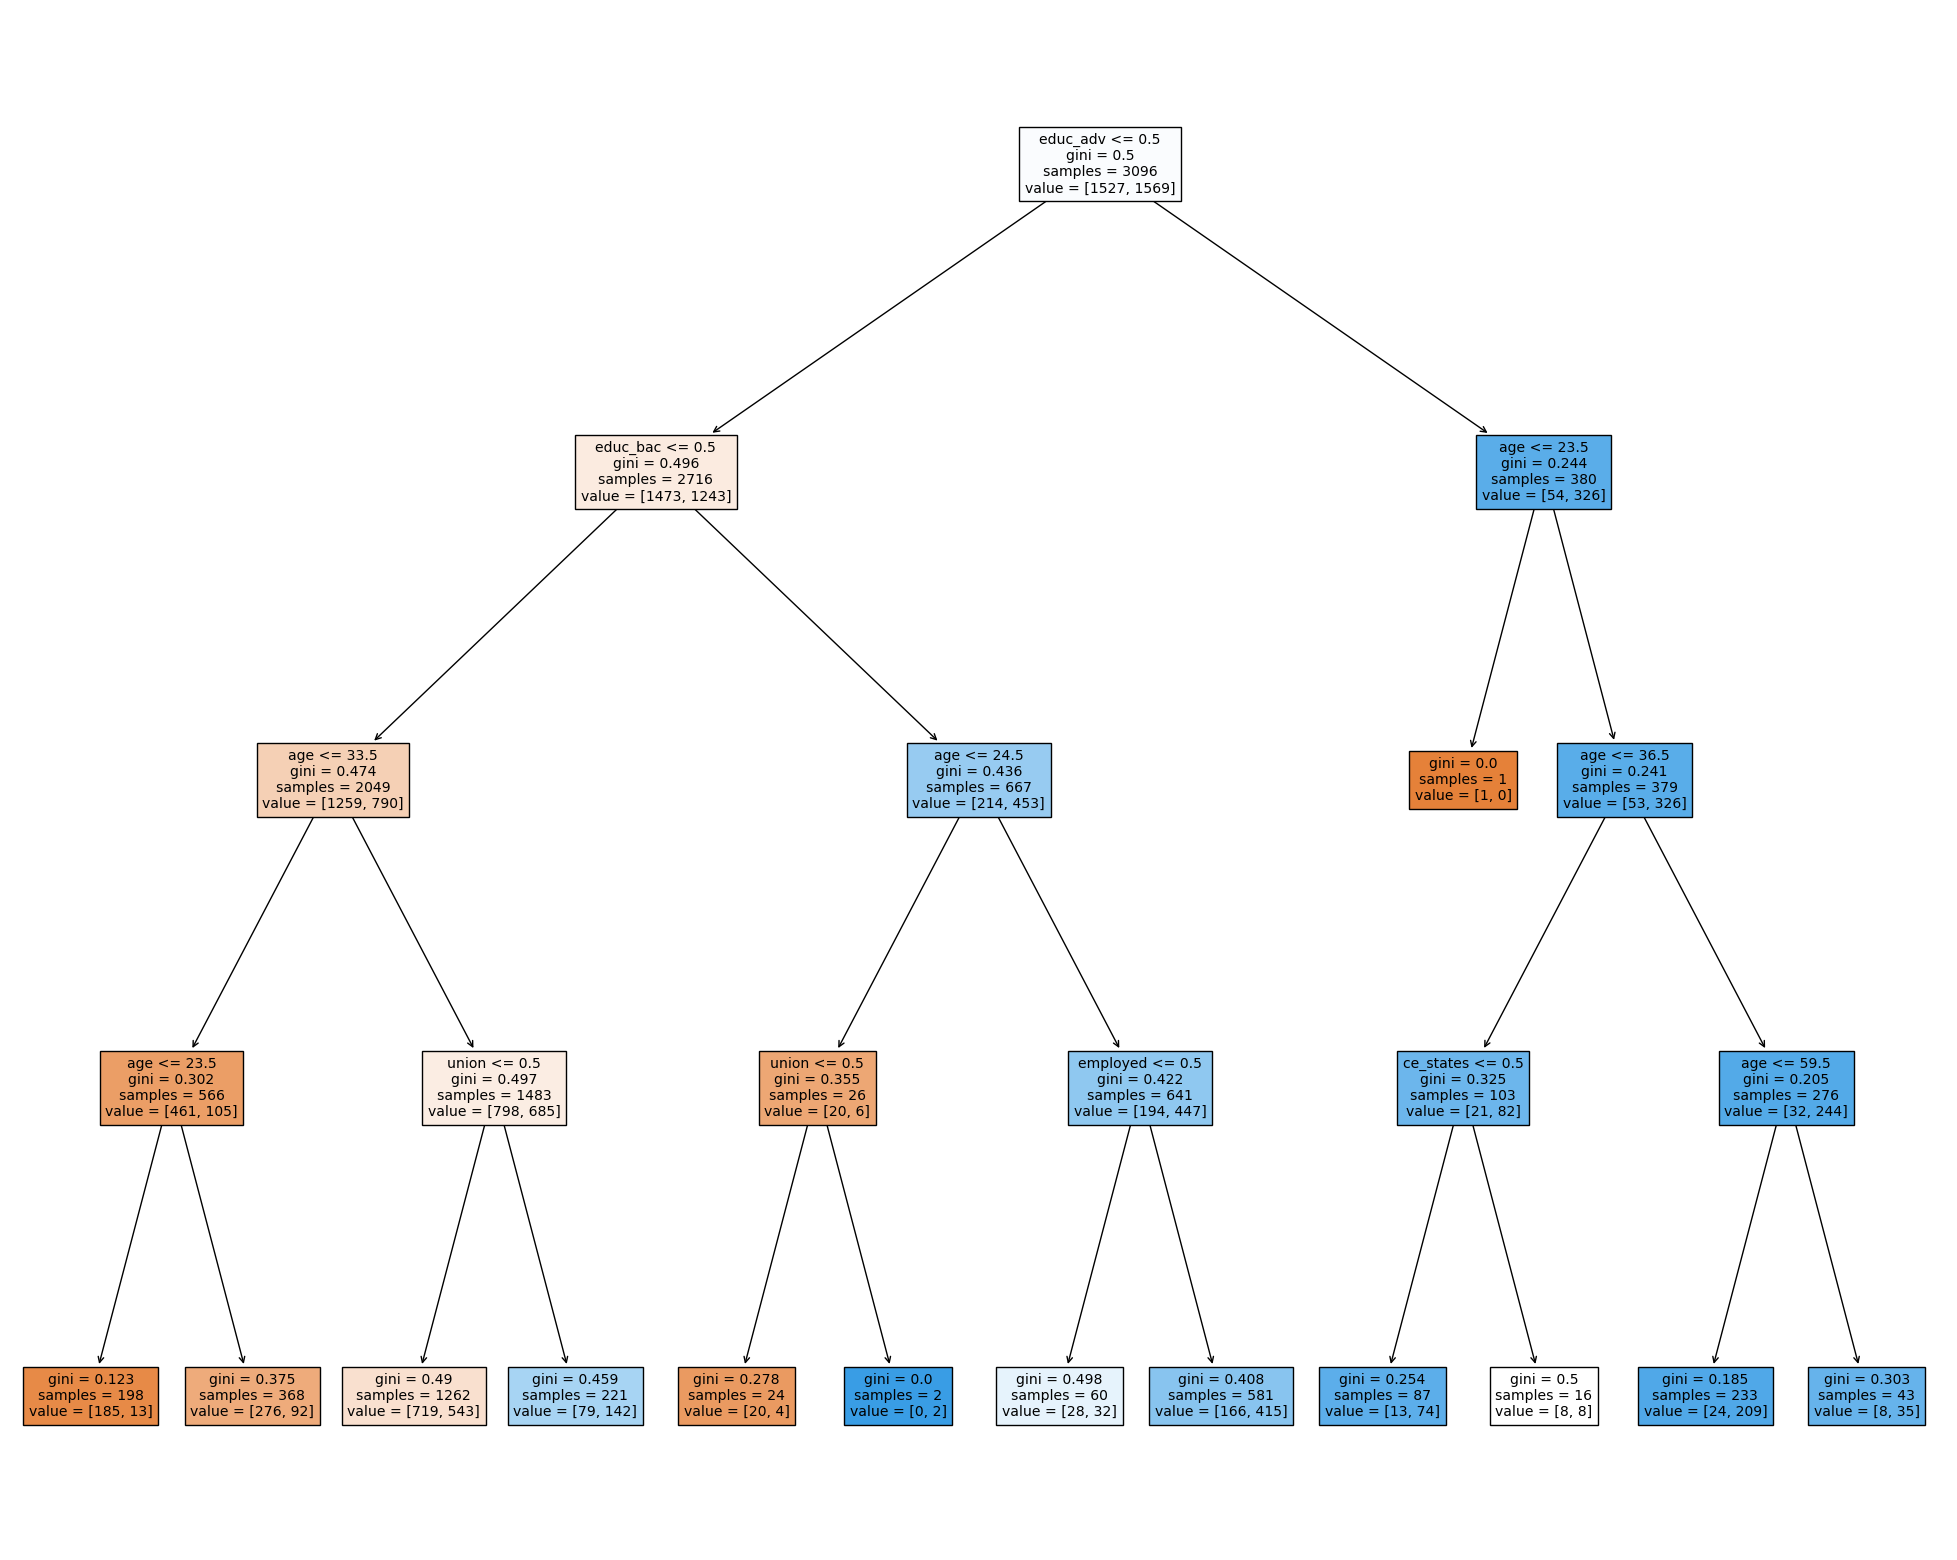

In [37]:
plot_tree(dt, features)

In [38]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

race0 : {'statistical_parity': 0.3998351195383347, 'equalized_odds': 0.3143620897827766, 'equalized_outcome': 0.5542949756888168}
race1 : {'statistical_parity': 0.3391304347826087, 'equalized_odds': 0.13756063756063758, 'equalized_outcome': 0.43243243243243246}
female0 : {'statistical_parity': 0.4241960183767228, 'equalized_odds': 0.32392079842879473, 'equalized_outcome': 0.5452322738386308}
female1 : {'statistical_parity': 0.36592592592592593, 'equalized_odds': 0.2905552918841955, 'equalized_outcome': 0.5510204081632653}


In [39]:
calc_certainty(y_test, y_pred)

Confidence interval for the f1_score [0.95]:[0.574 - 0.637]


### Fair PCA


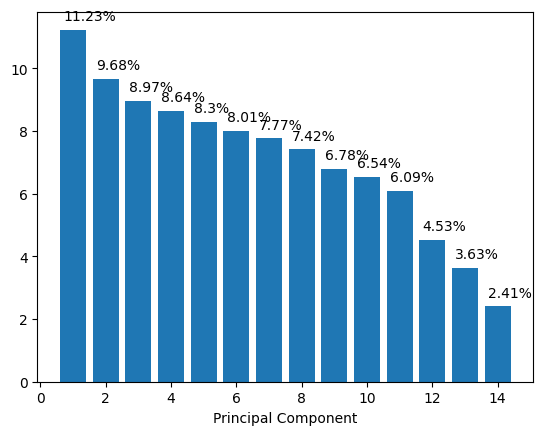

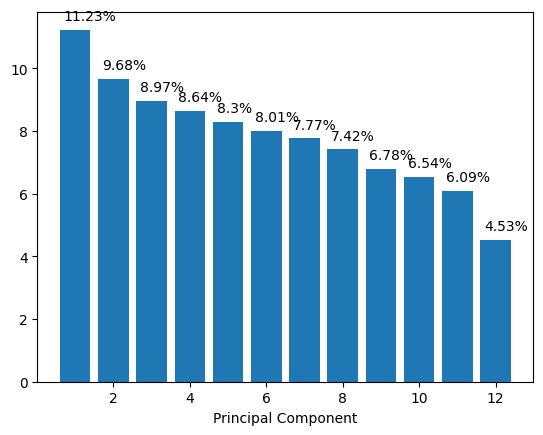

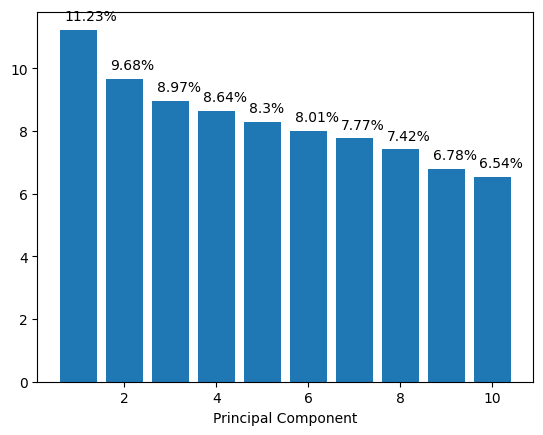

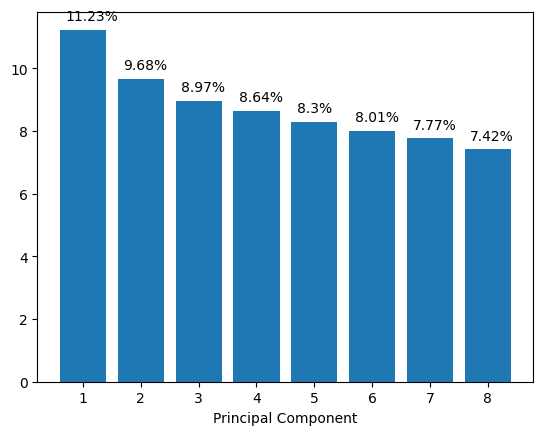

In [40]:
pca_14 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_12 = PCA(n_components=(len(features.columns)-6)) # trying different amounts of PCs
pca_10 = PCA(n_components=(len(features.columns)-8)) # trying different amounts of PCs
pca_8 = PCA(n_components=(len(features.columns)-10)) # trying different amounts of PCs
scaler = StandardScaler()
# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_14 = unfair_pca(pca_14, non_protected_features_scaled)
X_pca_12 = unfair_pca(pca_12, non_protected_features_scaled)
X_pca_10 = unfair_pca(pca_10, non_protected_features_scaled)
X_pca_8 = unfair_pca(pca_8, non_protected_features_scaled)

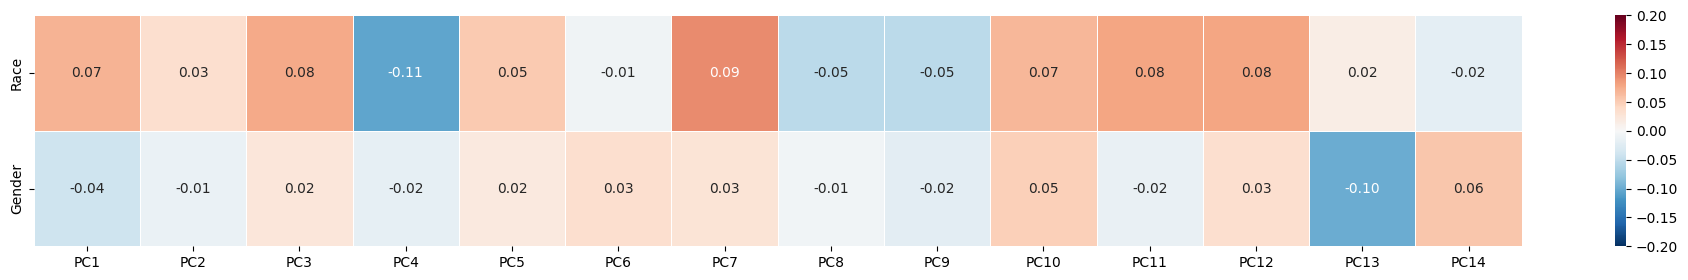

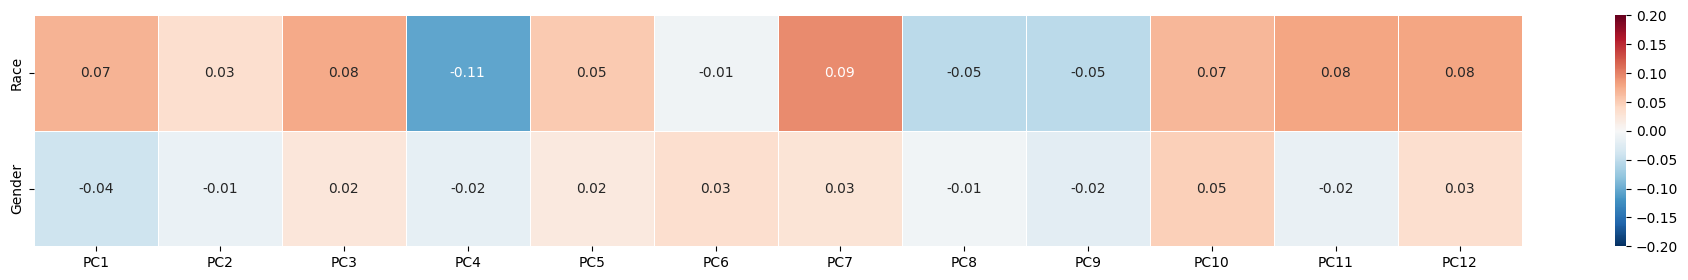

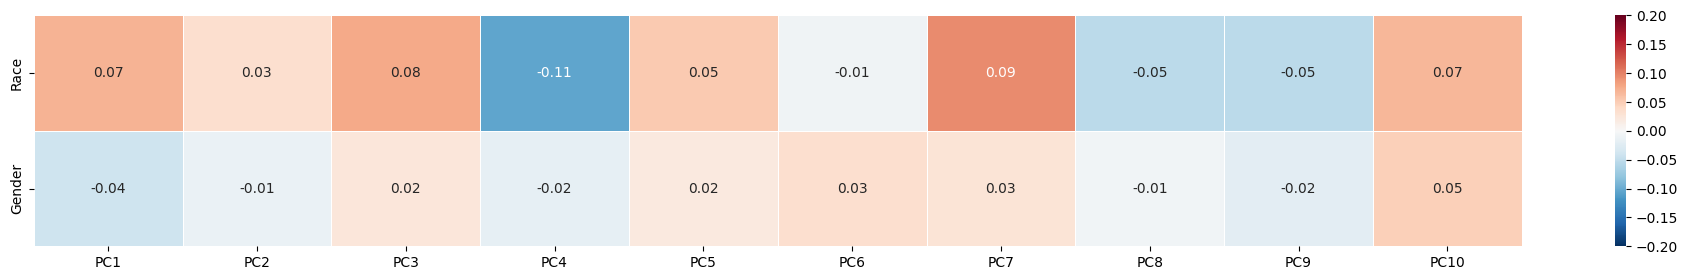

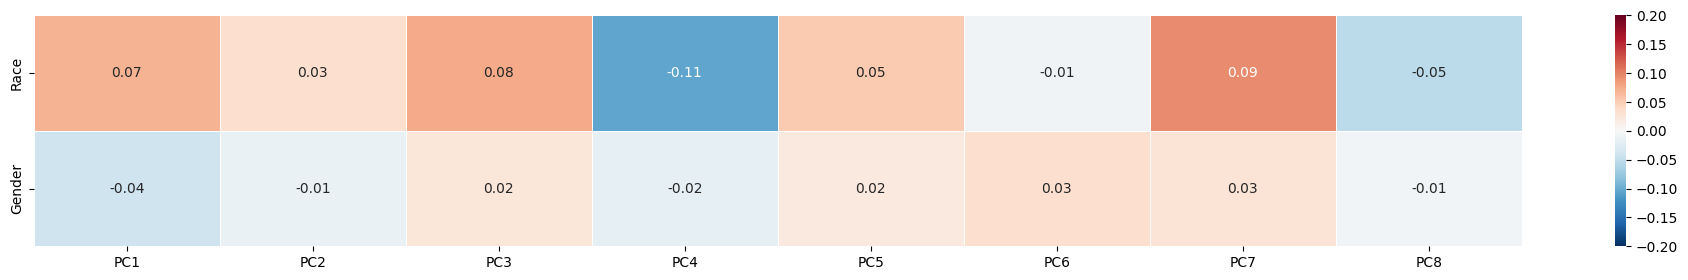

In [41]:
plot_pca_corr(X_pca_14, protected, groups)
plot_pca_corr(X_pca_12, protected, groups)
plot_pca_corr(X_pca_10, protected, groups)
plot_pca_corr(X_pca_8, protected, groups)

In [42]:

# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_14, pca_14, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error(X_pca_12, pca_12, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error(X_pca_10, pca_10, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error(X_pca_8, pca_8, non_protected_features_scaled_test)

1.229562524926396e-15
1.2216516511526237e-15
1.2115043168713103e-15
1.2272431624420333e-15
----------------------------------
0.10341938831079675
0.09959061668417678
0.09607355064076345
0.10214685001941876
----------------------------------
0.23475790325235713
0.22492038498775893
0.21861280243107506
0.23119466822901685
----------------------------------
0.3604481669412379
0.3571034371822077
0.3446299626752404
0.3603479608744991


In [43]:
X_projected_14, Z_14, U_14 = fair_pca(non_protected_features_scaled, protected, 14)
X_projected_12, Z_12, U_12 = fair_pca(non_protected_features_scaled, protected, 12)
X_projected_10, Z_10, U_10 = fair_pca(non_protected_features_scaled, protected, 10)
X_projected_8, Z_8, U_8 = fair_pca(non_protected_features_scaled, protected, 8)

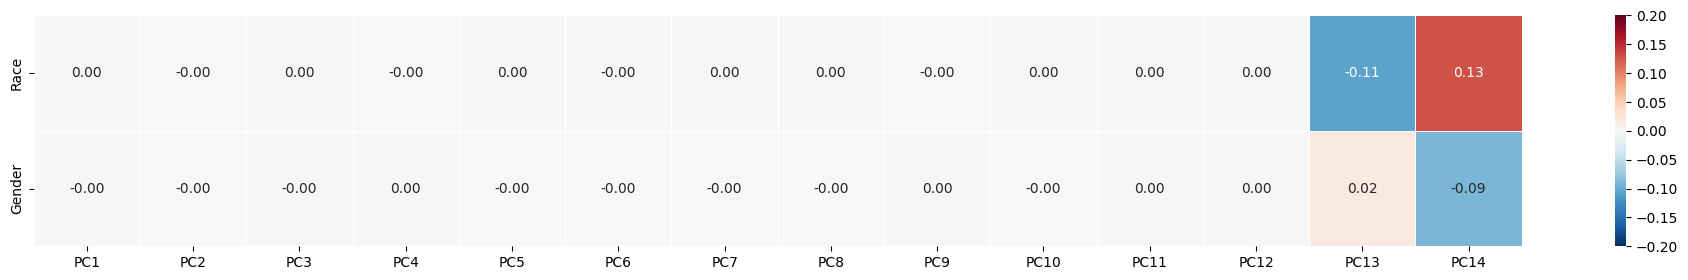

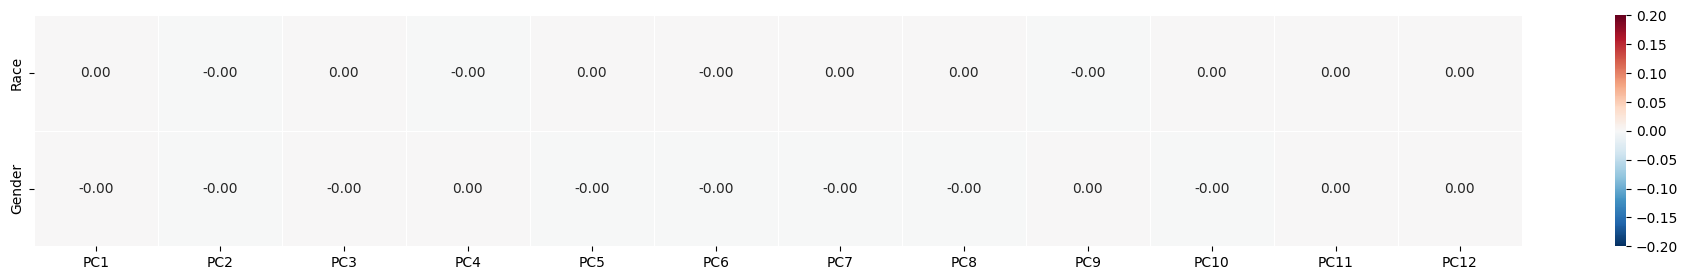

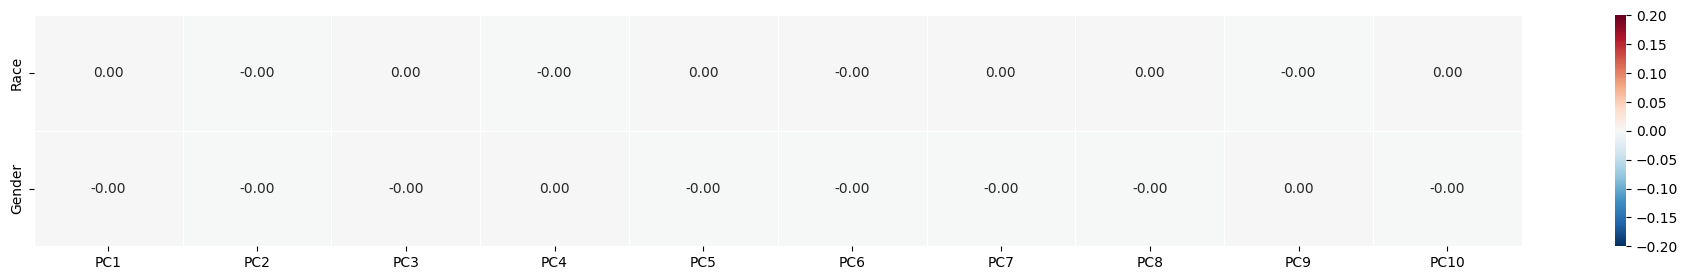

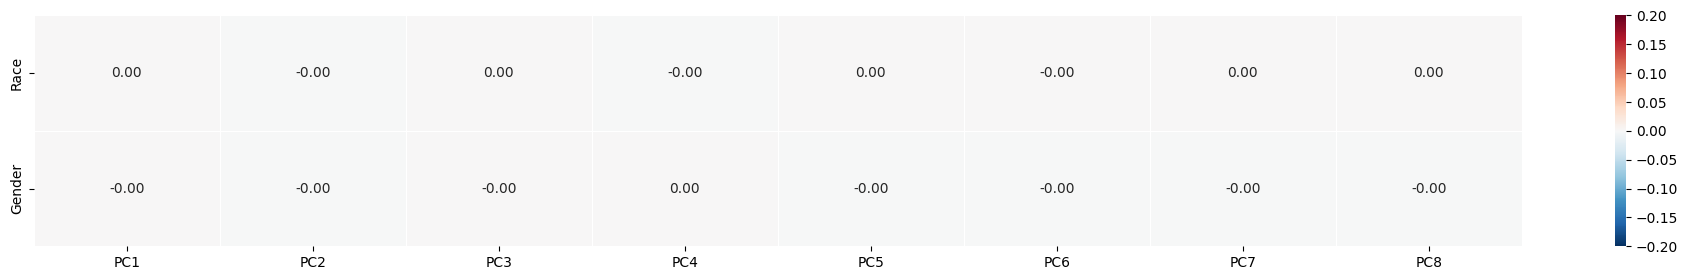

In [44]:
plot_pca_corr(X_projected_14, protected, groups)
plot_pca_corr(X_projected_12, protected, groups)
plot_pca_corr(X_projected_10, protected, groups)
plot_pca_corr(X_projected_8, protected, groups)

In [45]:
# project test data
X_test_projected_14 = non_protected_features_scaled_test @ U_14
X_test_projected_12 = non_protected_features_scaled_test @ U_12
X_test_projected_10 = non_protected_features_scaled_test @ U_10
X_test_projected_8 = non_protected_features_scaled_test @ U_8

reconstruction_error_fair_pca(X_projected_14, X_test_projected_14, U_14, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_12, X_test_projected_12, U_12, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_10, X_test_projected_10, U_10, non_protected_features_scaled_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_8, X_test_projected_8, U_8, non_protected_features_scaled_test)

0.27511856677759894
0.2718229943698536
0.2697598636301388
0.27391951167386147
----------------------------------
0.27511856677759894
0.2718229943698536
0.2697598636301389
0.27391951167386147
----------------------------------
0.34777723295908786
0.3384388949940806
0.3337295036064551
0.3442572919758476
----------------------------------
0.4400227247761442
0.43332624581278645
0.4155070624900644
0.4390524120360068


Balanced accuracy on test set: 0.6496474559660251
Precision on test set: 0.7162162162162162
Recall on test set: 0.48623853211009177
F1 score on test set: 0.5792349726775957


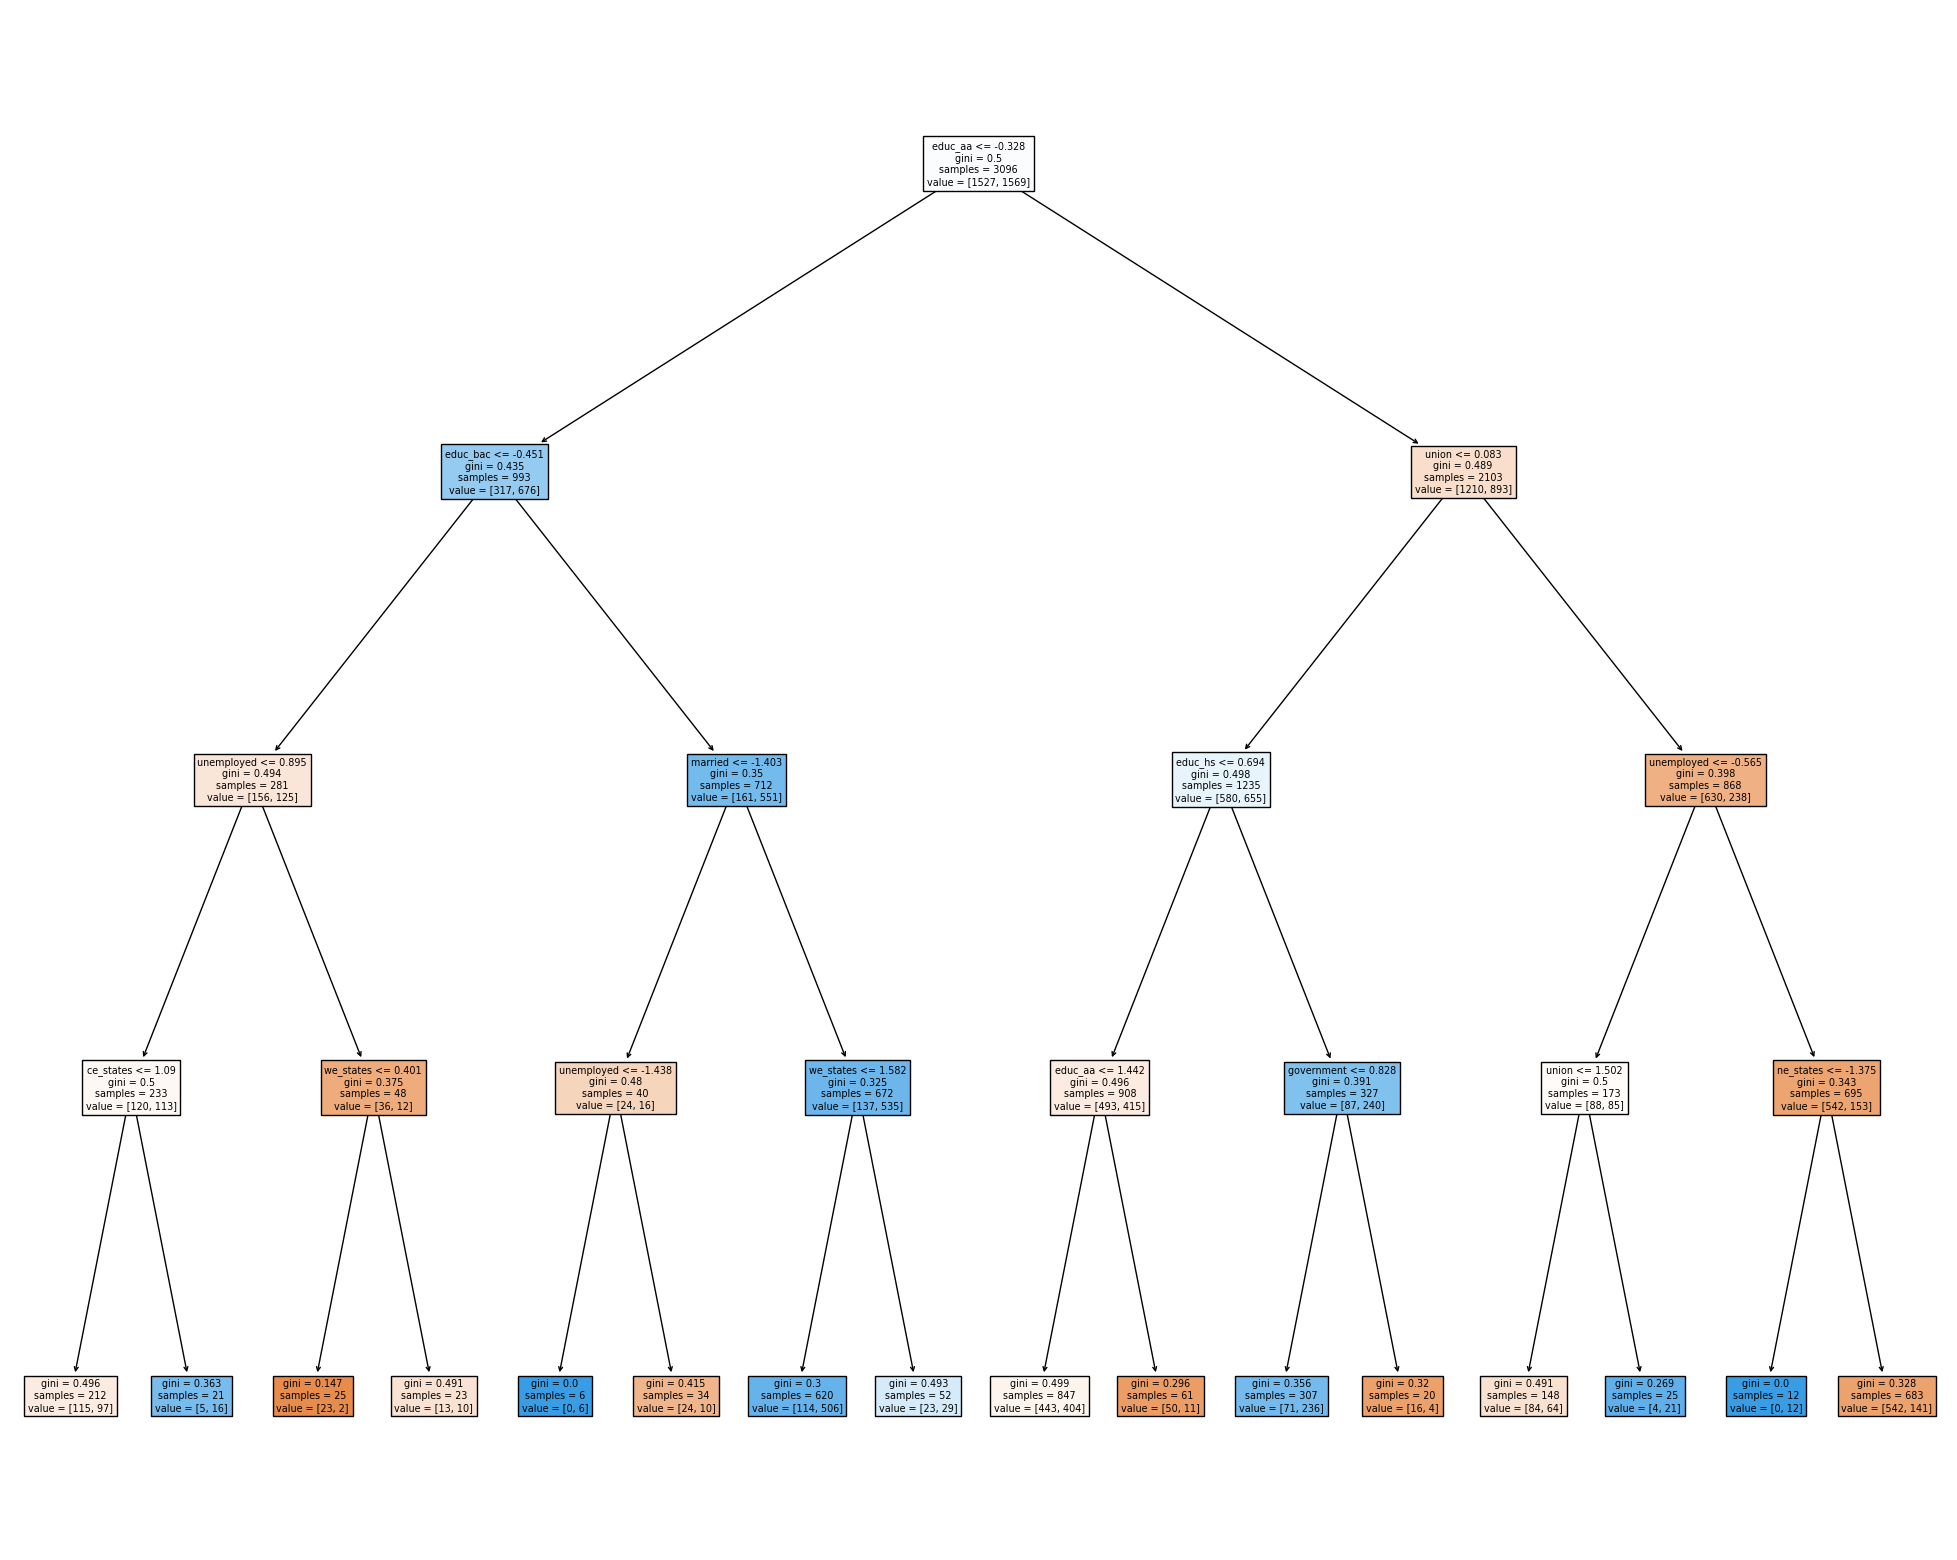

In [46]:
# run decision tree on fair PCA data with 14 components
dt_14 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_14.fit(X_projected_14, y_train)
# evaluate the model on the test set
y_pred_14 = dt_14.predict(X_test_projected_14)
metric_scores_14 = calculate_metrics(y_test, y_pred_14)
print("Balanced accuracy on test set:", metric_scores_14['accuracy'])
print("Precision on test set:", metric_scores_14['precision'])
print("Recall on test set:", metric_scores_14['recall'])
print("F1 score on test set:", metric_scores_14['f1_score'])
plot_tree(dt_14, features)

Balanced accuracy on test set: 0.6496474559660251
Precision on test set: 0.7162162162162162
Recall on test set: 0.48623853211009177
F1 score on test set: 0.5792349726775957


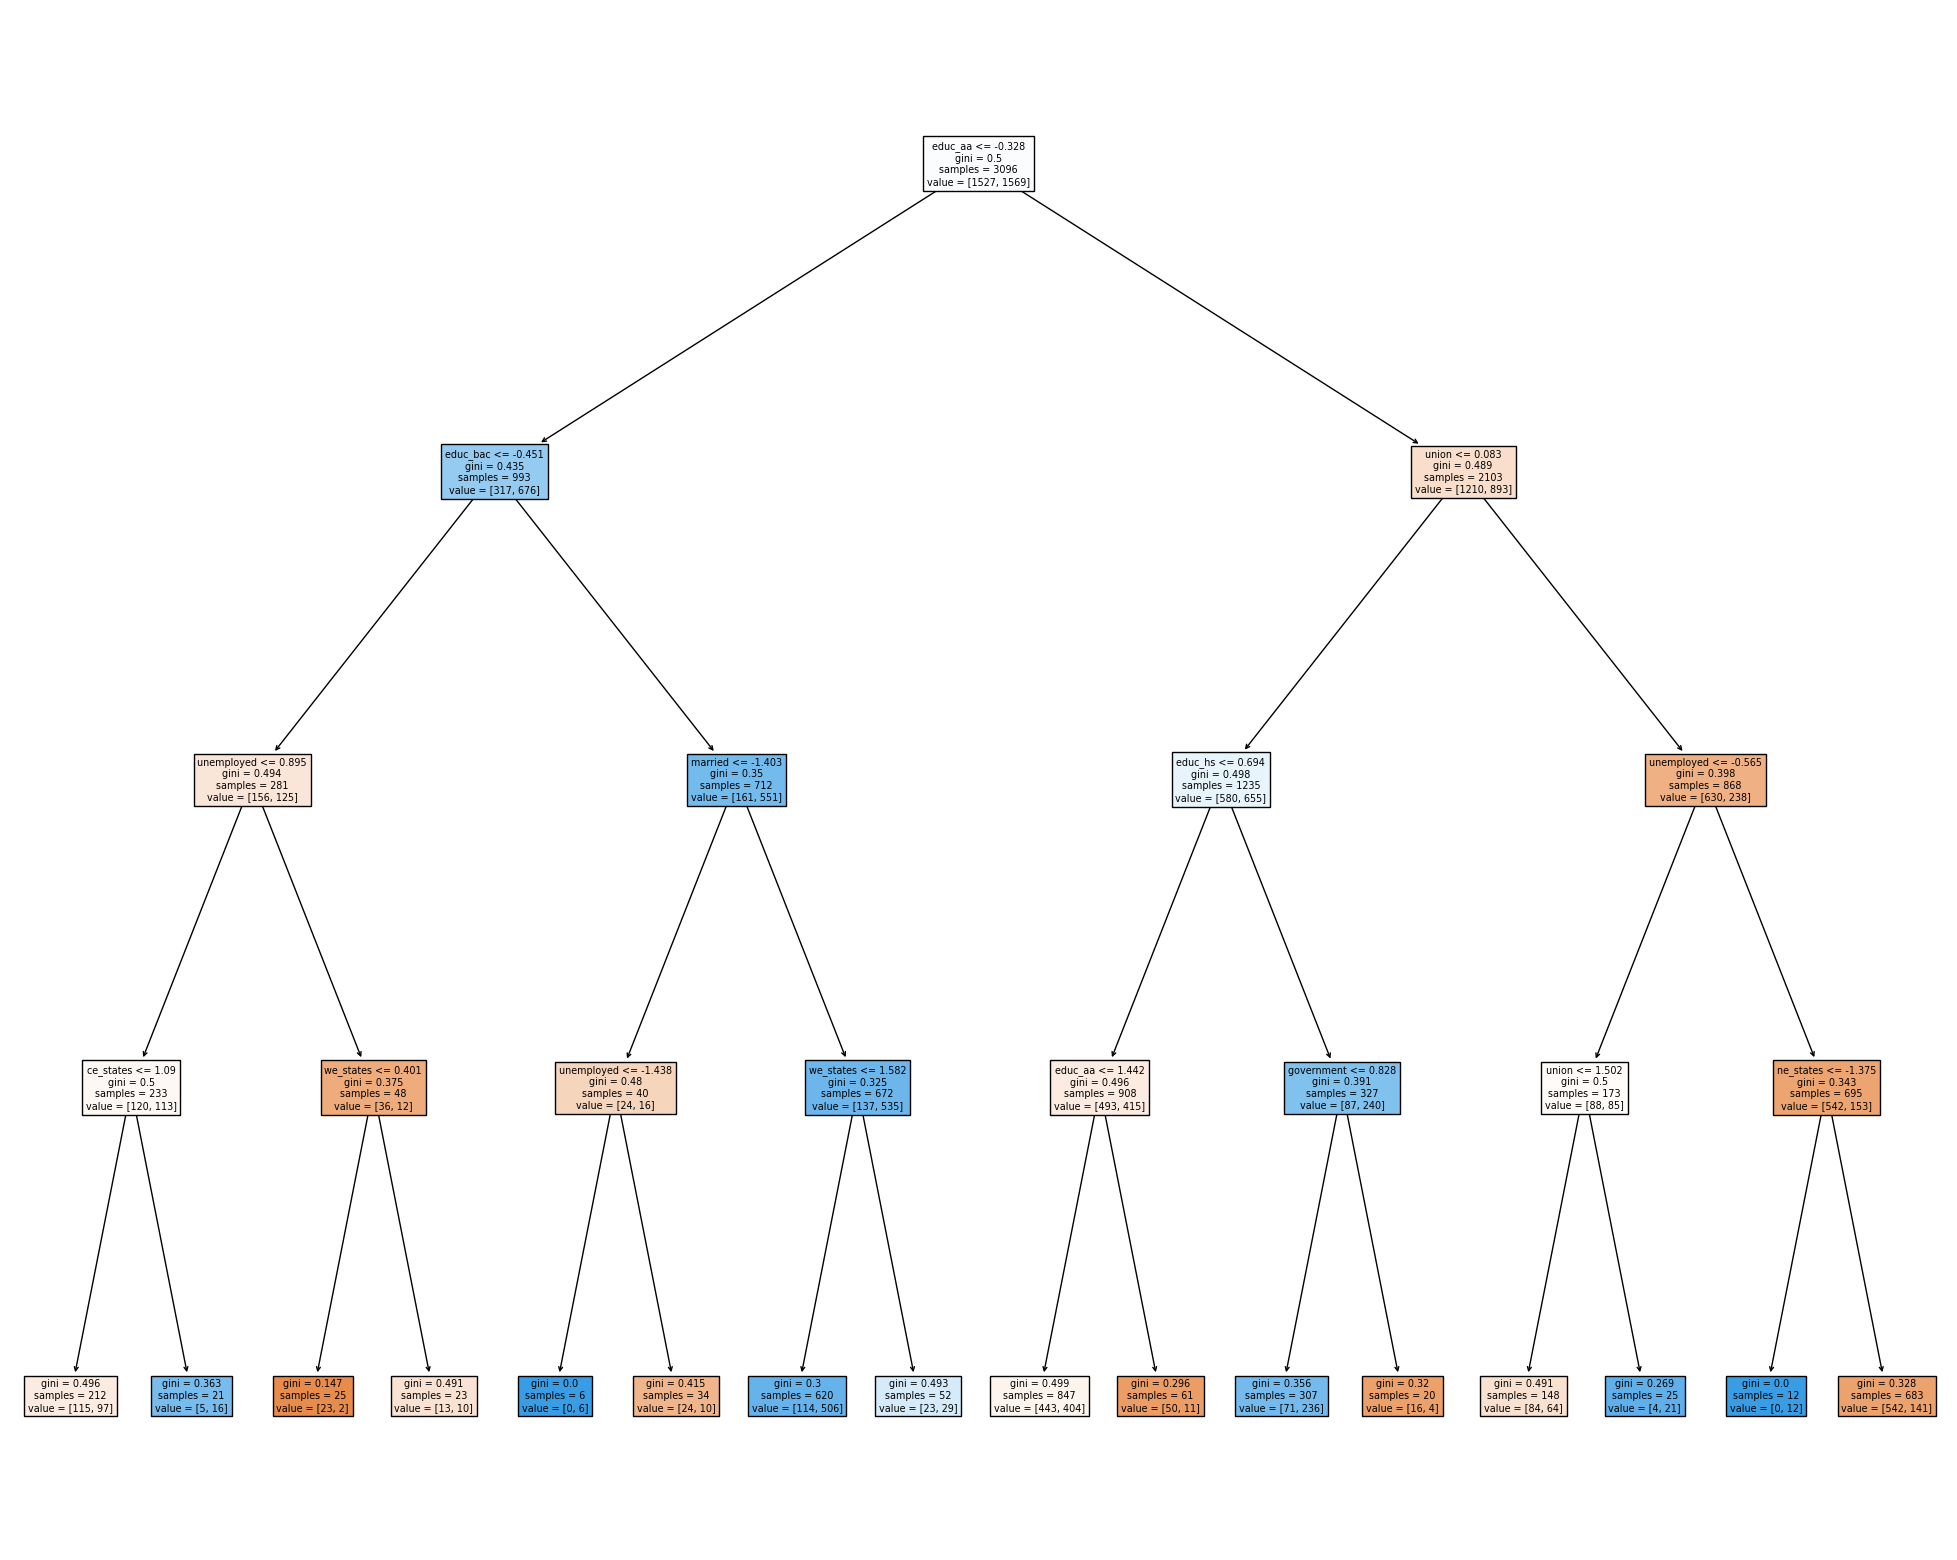

In [47]:
# run decision tree on fair PCA data with 12 components
dt_12 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_12.fit(X_projected_12, y_train)
# evaluate the model on the test set
y_pred_12 = dt_12.predict(X_test_projected_12)
metric_scores_12 = calculate_metrics(y_test, y_pred_12)
print("Balanced accuracy on test set:", metric_scores_12['accuracy'])
print("Precision on test set:", metric_scores_12['precision'])
print("Recall on test set:", metric_scores_12['recall'])
print("F1 score on test set:", metric_scores_12['f1_score'])

plot_tree(dt_12, features)

Balanced accuracy on test set: 0.6602827611865807
Precision on test set: 0.7278761061946902
Recall on test set: 0.5030581039755352
F1 score on test set: 0.5949367088607594


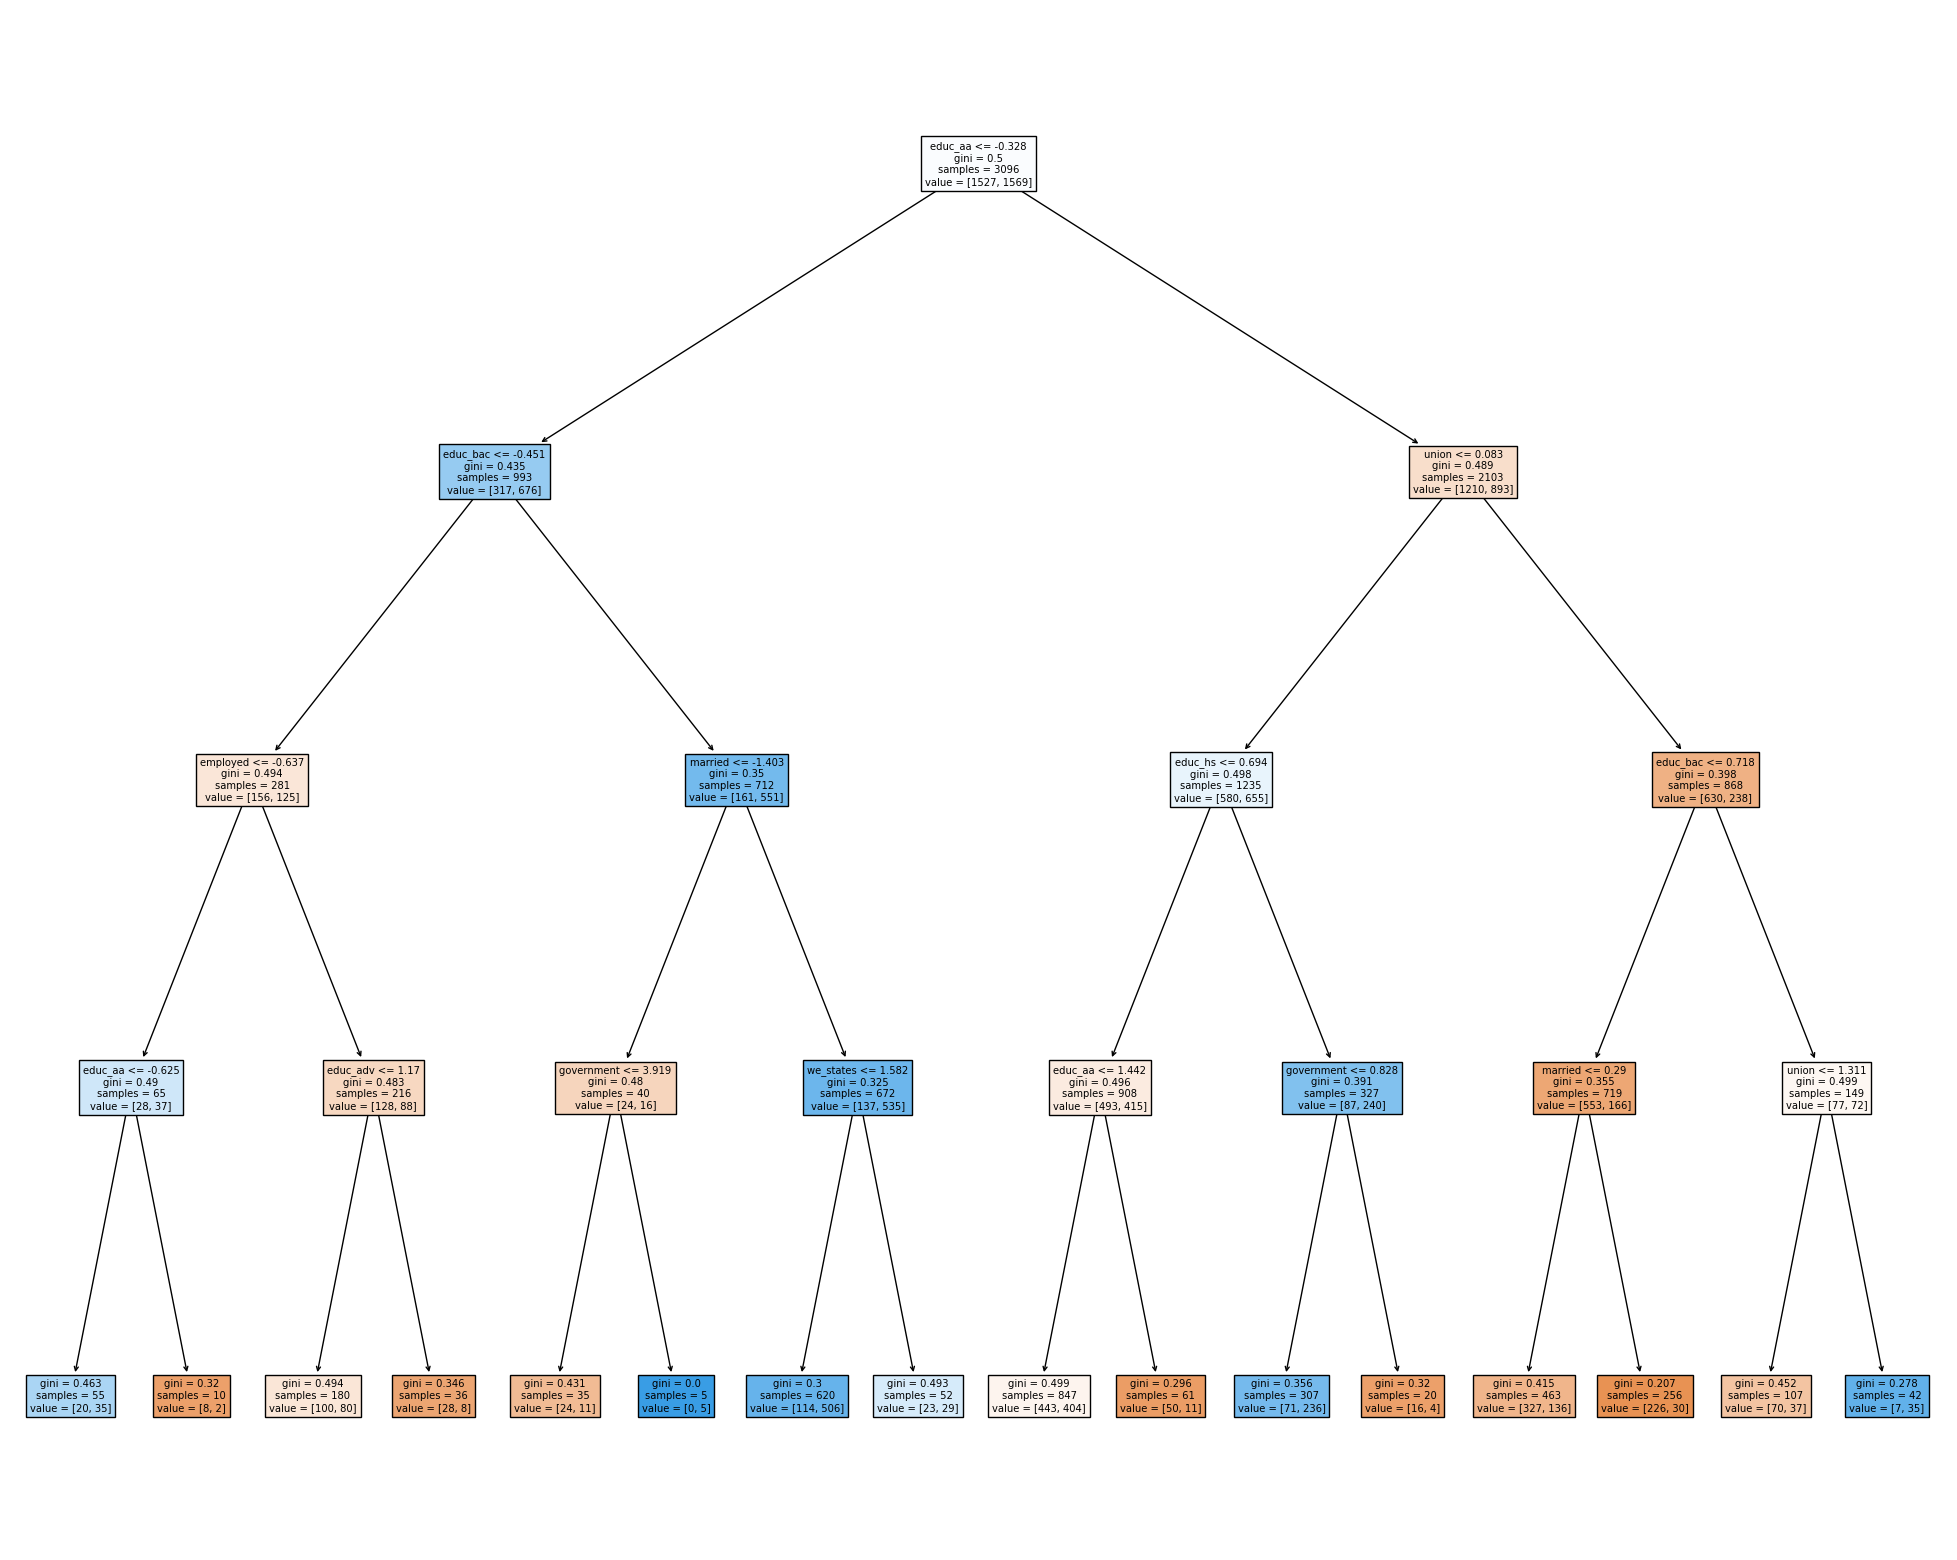

In [48]:
# run decision tree on fair PCA data with 12 components
dt_10 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_10.fit(X_projected_10, y_train)
# evaluate the model on the test set
y_pred_10 = dt_10.predict(X_test_projected_10)
metric_scores_10 = calculate_metrics(y_test, y_pred_10)
print("Balanced accuracy on test set:", metric_scores_10['accuracy'])
print("Precision on test set:", metric_scores_10['precision'])
print("Recall on test set:", metric_scores_10['recall'])
print("F1 score on test set:", metric_scores_10['f1_score'])

plot_tree(dt_10, features)

Balanced accuracy on test set: 0.649132478516139
Precision on test set: 0.7053763440860215
Recall on test set: 0.5015290519877675
F1 score on test set: 0.5862377122430741


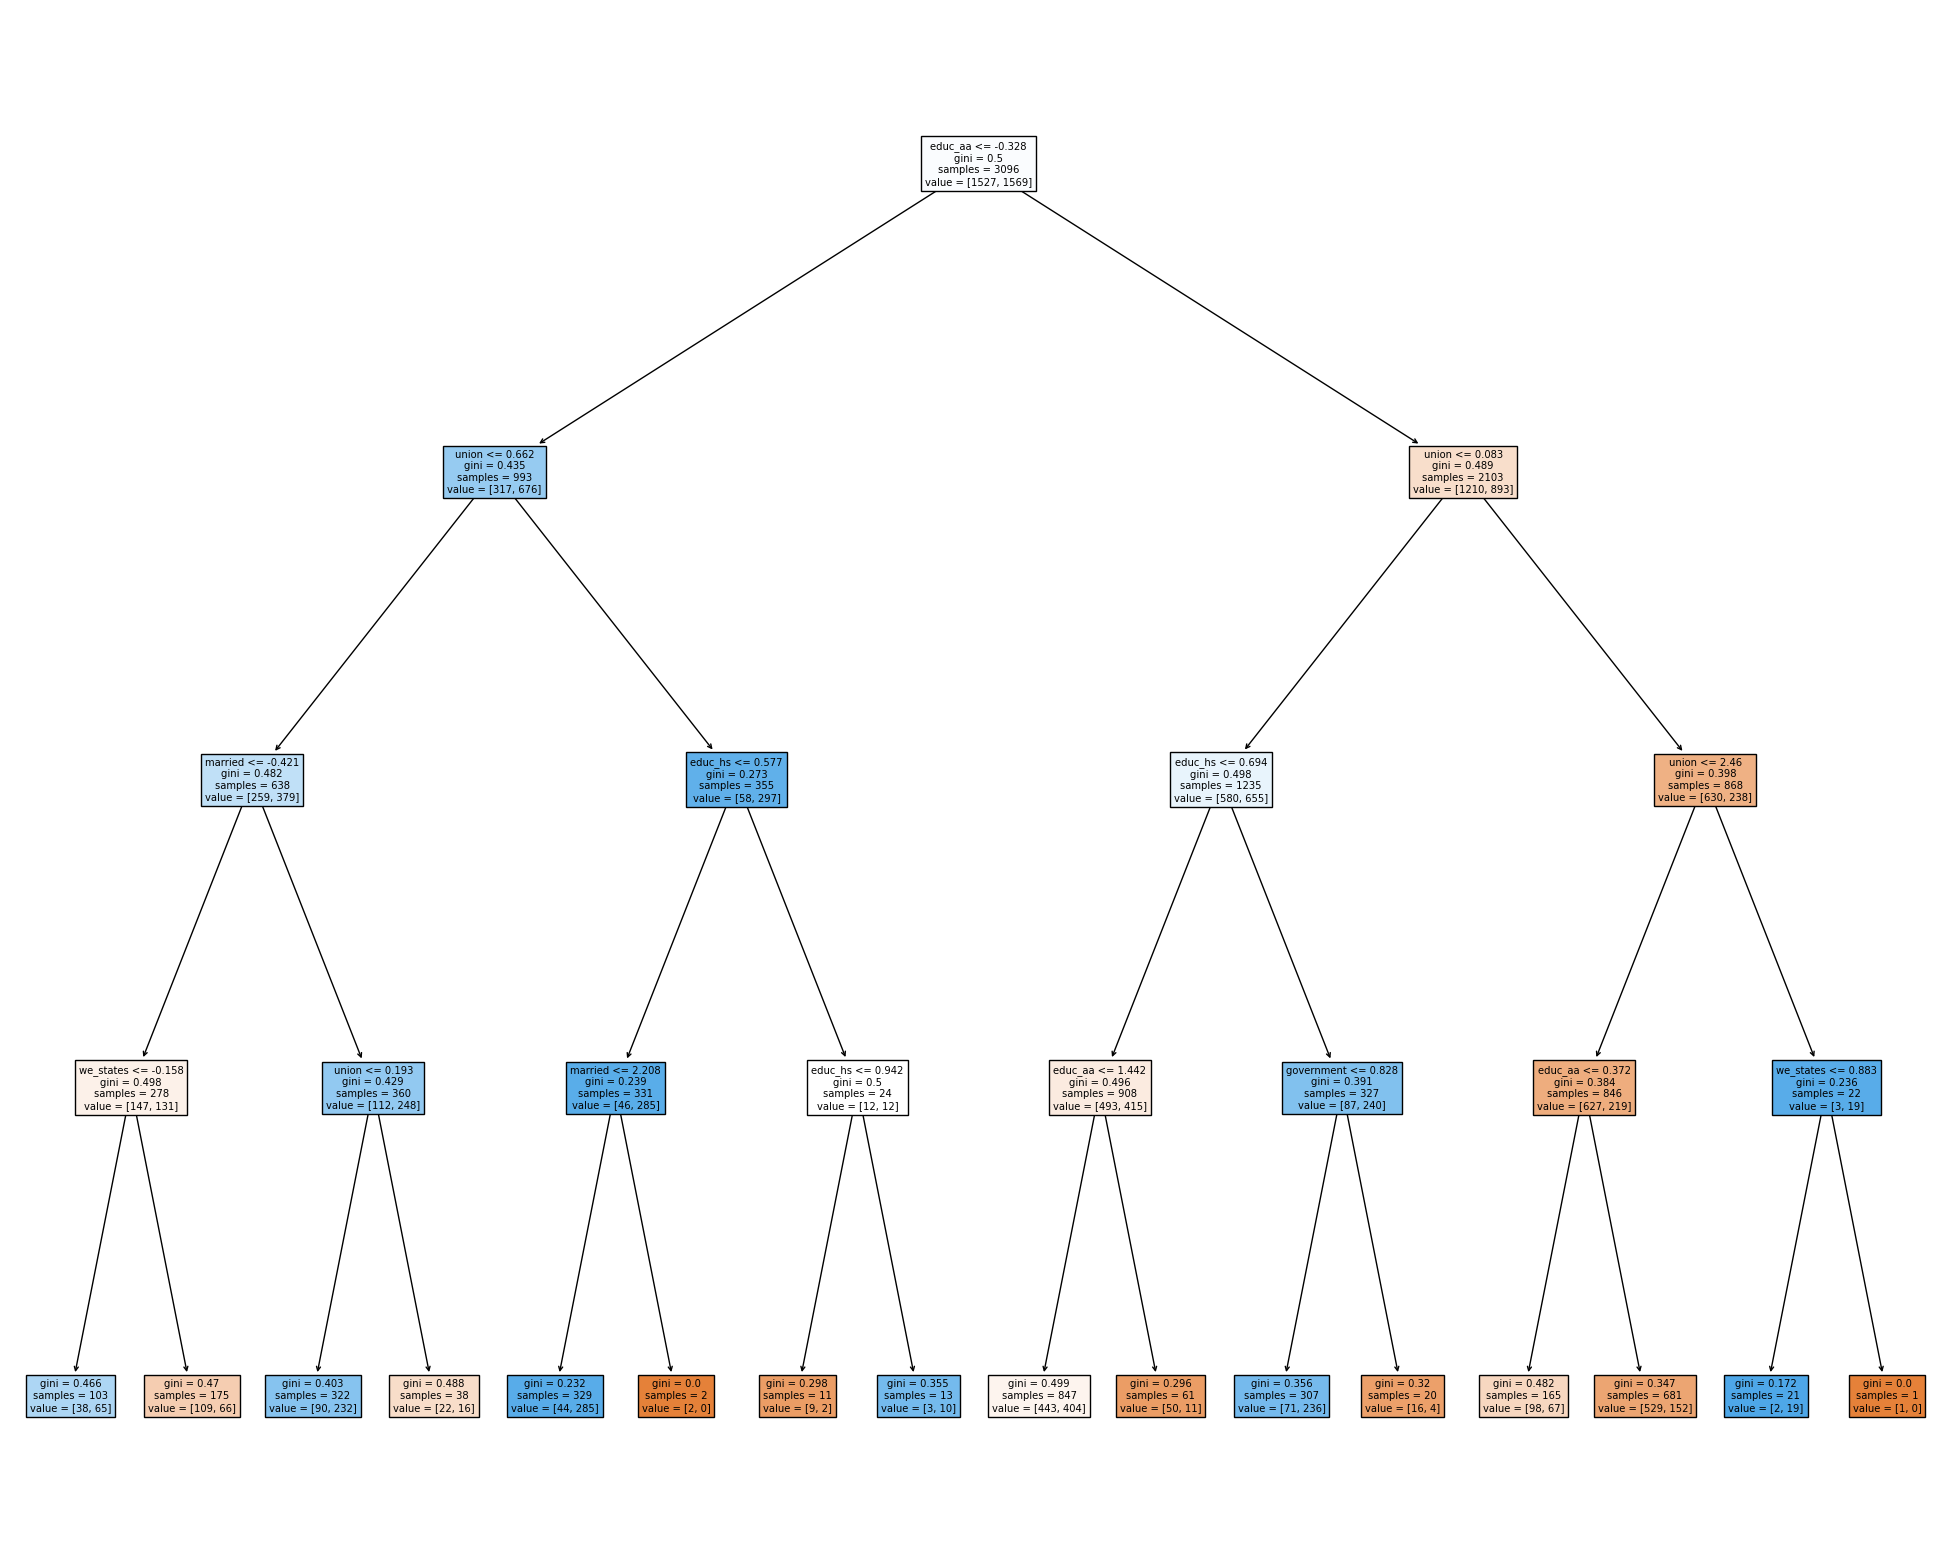

In [49]:
# run decision tree on fair PCA data with 12 components
dt_8 = DecisionTreeClassifier(max_depth=4)

# fit the model to the training data
dt_8.fit(X_projected_8, y_train)
# evaluate the model on the test set
y_pred_8 = dt_8.predict(X_test_projected_8)
metric_scores_8 = calculate_metrics(y_test, y_pred_8)
print("Balanced accuracy on test set:", metric_scores_8['accuracy'])
print("Precision on test set:", metric_scores_8['precision'])
print("Recall on test set:", metric_scores_8['recall'])
print("F1 score on test set:", metric_scores_8['f1_score'])

plot_tree(dt_8, features)

In [50]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics_14 = calculate_fairness_metrics(y_test, y_pred_14, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_12 = calculate_fairness_metrics(y_test, y_pred_12, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_10 = calculate_fairness_metrics(y_test, y_pred_10, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_8 = calculate_fairness_metrics(y_test, y_pred_8, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

race0 : {'statistical_parity': 0.3998351195383347, 'equalized_odds': 0.3143620897827766, 'equalized_outcome': 0.5542949756888168}
race1 : {'statistical_parity': 0.3391304347826087, 'equalized_odds': 0.13756063756063758, 'equalized_outcome': 0.43243243243243246}
female0 : {'statistical_parity': 0.4241960183767228, 'equalized_odds': 0.32392079842879473, 'equalized_outcome': 0.5452322738386308}
female1 : {'statistical_parity': 0.36592592592592593, 'equalized_odds': 0.2905552918841955, 'equalized_outcome': 0.5510204081632653}
----------------------------------
race0 : {'statistical_parity': 0.3998351195383347, 'equalized_odds': 0.3143620897827766, 'equalized_outcome': 0.5542949756888168}
race1 : {'statistical_parity': 0.3391304347826087, 'equalized_odds': 0.13756063756063758, 'equalized_outcome': 0.43243243243243246}
female0 : {'statistical_parity': 0.4241960183767228, 'equalized_odds': 0.32392079842879473, 'equalized_outcome': 0.5452322738386308}
female1 : {'statistical_parity': 0.3659259